# TOPIC EXTRACTION FOR TRANSPORT ELECTRIFICATION PAPERS

# 1. LOAD ENVIRONMENT

In [2]:
import sys, jupyter_client, ipykernel, zmq
print(sys.executable)
print("jc", jupyter_client.__version__, "ik", ipykernel.__version__, "zmq", zmq.pyzmq_version())


/Users/andriohead/miniconda3/envs/02_Topics_Env/bin/python
jc 7.4.9 ik 6.29.5 zmq 26.4.0


In [3]:
# AI_TOPICS (Python 3.11.11)

import pandas as pd
import numpy as np
import json
import time
import random
import nbformat
import ast
import joblib
import torch
import os
import csv
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from packaging import version
import contextlib
import io
import openai
from openai import OpenAI
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import igraph as ig
import unicodedata
import plotly.io as pio

# Processing data
import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer

import os, glob, re, unicodedata


from tqdm import tqdm
from sentence_transformers import SentenceTransformer


import sklearn 
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances
from sklearn.neighbors import NearestNeighbors

from tqdm import tqdm  # Para mostrar barra de progreso
from pathlib import Path

from sentence_transformers import SentenceTransformer
#from umap import UMAP

import gc; gc.collect()


import pickle

from gensim.models import CoherenceModel                        # Coherence model
from gensim.corpora import Dictionary
from gensim.models import Phrases
from gensim.models.phrases import Phrases, Phraser

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from scipy.stats import f_oneway, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse.csgraph import connected_components

import bertopic
from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.backend import BaseEmbedder
from bertopic.cluster import BaseCluster
from bertopic.dimensionality import BaseDimensionalityReduction
import hdbscan

import math

from pyvis.network import Network
import networkx as nx

# Embedding coherence
from itertools import combinations
from gensim.models import KeyedVectors
from collections import defaultdict
from collections import Counter

import networkx as nx
import igraph as ig
import leidenalg

#NEW EMBEDDINGS
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
import hdbscan
import umap

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

In [4]:
## Load AI configuration
con_file = open("02_AI_Topics_Models_Data/key_OpenAI.json")
config = json.load(con_file)
con_file.close()

## Initialize client
client = openai.OpenAI(api_key=config['apikey'])

# First test
models = client.models.list()

for model in models:
    print(model.id)

gpt-4-0613
gpt-4
gpt-3.5-turbo
gpt-5.2-codex
gpt-4o-mini-tts-2025-12-15
gpt-realtime-mini-2025-12-15
gpt-audio-mini-2025-12-15
chatgpt-image-latest
davinci-002
babbage-002
gpt-3.5-turbo-instruct
gpt-3.5-turbo-instruct-0914
dall-e-3
dall-e-2
gpt-4-1106-preview
gpt-3.5-turbo-1106
tts-1-hd
tts-1-1106
tts-1-hd-1106
text-embedding-3-small
text-embedding-3-large
gpt-4-0125-preview
gpt-4-turbo-preview
gpt-3.5-turbo-0125
gpt-4-turbo
gpt-4-turbo-2024-04-09
gpt-4o
gpt-4o-2024-05-13
gpt-4o-mini-2024-07-18
gpt-4o-mini
gpt-4o-2024-08-06
chatgpt-4o-latest
gpt-4o-audio-preview
gpt-4o-realtime-preview
omni-moderation-latest
omni-moderation-2024-09-26
gpt-4o-realtime-preview-2024-12-17
gpt-4o-audio-preview-2024-12-17
gpt-4o-mini-realtime-preview-2024-12-17
gpt-4o-mini-audio-preview-2024-12-17
o1-2024-12-17
o1
gpt-4o-mini-realtime-preview
gpt-4o-mini-audio-preview
o3-mini
o3-mini-2025-01-31
gpt-4o-2024-11-20
gpt-4o-search-preview-2025-03-11
gpt-4o-search-preview
gpt-4o-mini-search-preview-2025-03-11
gpt

# 2. Pretraining & Embeddings - Full_Texts and SciBERT

In [ ]:
def preprocess_text_for_scibert (text: str) -> str:
    if not text:
        return ""
    text_pp = unicodedata.normalize("NFKC", str(text))
    text_pp = text_pp.replace("\u00A0", " ")            # Spaces no breakables
    text_pp = re.sub(r'[ \t]+', ' ', text_pp)           # Multiple spaces
    text_pp = re.sub(r'\s*\n+\s*', ' ', text_pp)        # Ligne jumps
    # text_pp = re.sub(r'[^\x00-\x7F]+', ' ', text_pp)

    return text_pp.strip() 

## 2.1 Implementation: Embeddings for full text

### 2.1.1 SCI BERT

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import torch
import gc

def generate_embeddings_optimized (df, model_name='allenai/scibert_scivocab_uncased', 
                                      output_file="embeddings.parquet"):
    """
    Configuración OPTIMIZADA para:
    - 16GB RAM total (≈12GB disponibles)
    - Intel Iris (GPU integrada, poca memoria)
    - Intel i7 (4 cores)
    """
    
    # 1. FORZAR CPU - La GPU integrada es más lenta para transformers
    device = 'cpu'
    print("⚡ Usando CPU (GPU integrada no acelerará SciBERT)")
    
    # 2. Cargar modelo con optimizaciones CPU
    model = SentenceTransformer(
        model_name, 
        device=device,
        # Optimizaciones para CPU
        model_kwargs={'torch_dtype': torch.float32}  # Usar float32, no float16
    )
    
    # 3. Batch size MUCHO más pequeño
    # Estimación: cada embedding ~3KB * batch_size + overhead
    # Con 12GB disponibles, máximo seguro:
    SAFE_BATCH_SIZE = 64  # ¡Reducido dramáticamente!
    print(f"📦 Batch size seguro: {SAFE_BATCH_SIZE} (por memoria limitada)")
    
    # 4. Preprocesar textos (usa tu función)
    texts = df["chunk_text"].fillna("").astype(str).tolist()
    
    # 5. Procesar con gestión AGGRESIVA de memoria
    all_embeddings = []
    
    for i in tqdm(range(0, len(texts), SAFE_BATCH_SIZE), 
                  desc="Generando embeddings", 
                  unit="batch"):
        
        batch_texts = texts[i:i + SAFE_BATCH_SIZE]
        
        # Preprocesamiento del batch
        processed_batch = [preprocess_text_for_scibert(t) for t in batch_texts]
        
        # Generar embeddings con batch interno PEQUEÑO
        try:
            batch_emb = model.encode(
                processed_batch,
                batch_size=4,  # Batch interno MUY pequeño
                show_progress_bar=False,
                convert_to_tensor=False,  # No usar tensor para ahorrar memoria
                normalize_embeddings=False,
                output_value="sentence_embedding"
            )
            
            all_embeddings.append(batch_emb.astype("float32"))
            
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                print(f"⚠️  Memoria insuficiente en batch {i}. Reduciendo...")
                # Procesar de a un texto
                for j, text in enumerate(processed_batch):
                    try:
                        single_emb = model.encode(
                            text,
                            show_progress_bar=False,
                            normalize_embeddings=False
                        )
                        all_embeddings.append(single_emb.reshape(1, -1).astype("float32"))
                    except:
                        # Vector cero como fallback
                        all_embeddings.append(np.zeros((1, 768), dtype="float32"))
            else:
                raise e
        
        # Limpiar memoria CADA batch
        gc.collect()
    
    # 6. Concatenar
    final_embeddings = np.vstack(all_embeddings)
    
    # 6. Crear DataFrame CON embeddings incluidos
    print("📊 Creando DataFrame final...")
    
    # Método 1: Lista de arrays numpy (recomendado)
    embeddings_list = [emb for emb in final_embeddings]
    
    result_df = pd.DataFrame({
        "doc_id": df["doc_id"].values,
        "sec_order": df["sec_order"].values,
        "label": df["label"].values,
        "sec_title": df["sec_title"].values,
        "chunk_id": df["chunk_id"].values,
        "chunk_text": df["chunk_text"].values,
        "chunk_emb": embeddings_list  # ← CORRECTO
    })
    
    # 7. Verificar
    print(f"✅ DataFrame creado: {len(result_df)} filas")
    print(f"   - Primera embedding shape: {result_df['chunk_emb'].iloc[0].shape}")
    print(f"   - Dimensión embeddings: {result_df['chunk_emb'].iloc[0].shape[0]}")
    
    # 8. Guardar
    result_df.to_parquet(output_file, compression='zstd')
    print(f"💾 Guardado: {output_file}")
    
    return result_df


In [ ]:
CHUNKS_FILE = "01_Extract_Information_Data/All_With_Conclusions_SD_Chunks_RAW.parquet"
OUTPUT_FILE = "03_Embeddings/Embeddings_RAW.parquet"

import os
os.environ['OMP_NUM_THREADS'] = '4'  # Usar tus 4 cores
os.environ['MKL_NUM_THREADS'] = '4'


In [ ]:
df = pd.read_parquet(CHUNKS_FILE)
embeddings_df = generate_embeddings_optimized(
    df, 
    output_file=OUTPUT_FILE
)

In [ ]:
CHUNKS_FILE = "01_Extract_Information_Data/All_With_Conclusions_SD_Chunks_HARD.parquet"
OUTPUT_FILE = "03_Embeddings/Embeddings_HARD.parquet"

import os
os.environ['OMP_NUM_THREADS'] = '4'  # Usar tus 4 cores
os.environ['MKL_NUM_THREADS'] = '4'

df = pd.read_parquet(CHUNKS_FILE)
embeddings_hard = generate_embeddings_optimized(
    df, 
    output_file=OUTPUT_FILE
)

In [ ]:
CHUNKS_FILE = "01_Extract_Information_Data/All_With_Conclusions_SD_Chunks_SOFT.parquet"
OUTPUT_FILE = "03_Embeddings/Embeddings_SOFT.parquet"

import os
os.environ['OMP_NUM_THREADS'] = '4'  # Usar tus 4 cores
os.environ['MKL_NUM_THREADS'] = '4'

df = pd.read_parquet(CHUNKS_FILE)
embeddings_hard = generate_embeddings_optimized(
    df, 
    output_file=OUTPUT_FILE
)

### 2.2.2 OPEN AI "EMBEDDING LARGE"

In [ ]:
CHECKPOINT_FILE = "emb_checkpoint.pkl"
OUTPUT_FILE = "03_Embeddings/Embeddings_OpenAI.parquet"
TEXT_COL    = "chunk_text"
ID_COLS     = ["doc_id", "label", "chunk_id_int", "chunk_id", "sec_title"]
BATCH_SIZE  = 32  # Tamaño de lote reducido para mejor manejo de memoria
CHECKPOINT_INTERVAL = 1000

if os.path.exists(CHECKPOINT_FILE):
    with open(CHECKPOINT_FILE, 'rb') as f:
        rows_openAI = pickle.load(f)
    print (f"Checkpoint loaded: {len(rows_openAI)} lines processed")
    start_idx = len(rows_openAI)
else:
    rows_openAI = []
    start_idx = 0

print (f"Processing from {start_idx}, until {len(df)}")
print(f"📊 Size of batch: {BATCH_SIZE} documents")

def get_openai_embeddings (texts, model="text-embedding-3-large"):
    resp = client.embeddings.create(
        model = model,
        input = texts
    )
    embs = np.array([d.embedding for d in resp.data], dtype="float32")

    return embs

for i in range(start_idx, len(df), BATCH_SIZE):
    end_idx = min(i + BATCH_SIZE, len(df))
    batch_indices = range(i, end_idx)
    
    # Preparar textos del lote
    batch_texts = []
    batch_metadata = []
    
    for idx in batch_indices:
        text = df[TEXT_COL].iloc[idx]
        processed_text = preprocess_text_for_scibert(text)

        # If chunk is empty
        if not processed_text:
            processed_text = "[EMPTY_CHUNK]"

        batch_texts.append(processed_text)
        
        # Guardar metadatos
        batch_metadata.append({
            "doc_id"        : df[ID_COLS[0]].iloc[idx],
            "label"         : df[ID_COLS[1]].iloc[idx],
            "chunk_int_id"  : df[ID_COLS[2]].iloc[idx],
            "chunk_id"      : df[ID_COLS[3]].iloc[idx],
            "sec_title"     : df[ID_COLS[4]].iloc[idx],
            "original_text" : text
        })
    
    # Generar embeddings por lote (MUCHO más eficiente)
    try:
        batch_embeddings = get_openai_embeddings(batch_texts)

        # Añadir resultados
        for metadata, emb in zip(batch_metadata, batch_embeddings):
            rows_openAI.append({
                "doc_id"        : metadata["doc_id"],
                "label"         : metadata["label"],
                "chunk_int_id"  : metadata["chunk_int_id"],
                "chunk_id"      : metadata["chunk_id"],
                "chunk_title"   : metadata["sec_title"],
                "chunk_text"    : metadata["original_text"],
                "chunk_emb"     : emb
            })
        
        print(f"✅ Batch {i//BATCH_SIZE + 1} processed: index {i}-{end_idx-1}")
        
    except Exception as e:
        print(f"❌ Error in batch {i}-{end_idx-1}: {e}")
        # Procesar individualmente como fallback
        for idx in batch_indices:
            try:
                text = df[TEXT_COL].iloc[idx]
                processed_text = preprocess_text_for_scibert(text)
                
                emb = get_openai_embeddings([processed_text])[0]
                
                rows_openAI.append({
                    "doc_id"        : df[ID_COLS[0]].iloc[idx],
                    "label"         : df[ID_COLS[1]].iloc[idx],
                    "chunk_int_id"  : df[ID_COLS[2]].iloc[idx],
                    "chunk_id"      : df[ID_COLS[3]].iloc[idx],
                    "sec_title"     : df[ID_COLS[4]].iloc[idx],
                    "chunk_text"    : text,
                    "chunk_emb"     : emb
                })
                print(f"✅ Text {idx} individually processed")
                
            except Exception as e2:
                print(f"❌ Critic error of text {idx}: {e2}")
                # Añadir fila vacía para mantener consistencia
                rows_openAI.append({
                    "doc_id"        : df[ID_COLS[0]].iloc[idx],
                    "label"         : df[ID_COLS[1]].iloc[idx],
                    "chunk_int_id"  : df[ID_COLS[2]].iloc[idx],
                    "chunk_id"      : df[ID_COLS[3]].iloc[idx],
                    "sec_title"     : df[ID_COLS[4]].iloc[idx],
                    "chunk_text"    : "ERROR_IN_PROCESSING",
                    "chunk_emb"     : np.zeros(768, dtype="float32")  # Vector cero como fallback
                })
    
    # Guardar checkpoint cada CHECKPOINT_INTERVAL
    if len(rows_openAI) % CHECKPOINT_INTERVAL == 0:
        with open(CHECKPOINT_FILE, 'wb') as f:
            pickle.dump(rows_openAI, f)
        print(f"💾 Checkpoint saved: {len(rows_openAI)} embeddings")

# Guardar resultados finales
print("🎉 Pre-processing finiched")
print(f"📈 Total generated embeddings: {len(rows_openAI)}")

# Limpiar checkpoint
if os.path.exists(CHECKPOINT_FILE):
    os.remove(CHECKPOINT_FILE)
    print("🧹 Checkpoint eliminado")

In [ ]:
df_embeddings = pd.DataFrame(rows_openAI)
df_embeddings.to_parquet(OUTPUT_FILE, index=False)

## TITLES

In [ ]:
df = pd.read_parquet("01_Extract_Information_Data/02_Clean_Sections_SD_02.parquet")


In [ ]:
#filtre = df('doc_id')
filtre = df[df['doc_id'].str.contains('0011', na=False)]
display(filtre)

In [ ]:
display(df['chunk_text'].iloc[441])

In [ ]:
Titles =  pd.read_csv("01_Extract_Information_Data/Clean_Titles_02.csv")
Titles = Titles[["0"]]
Titles = Titles.rename(columns={'0':'Title'})

#display(Titles)

#Titles = Titles.drop_duplicates(keep="first").sort_values("Title")
#print (Titles)


In [ ]:
freq = Titles.value_counts().reset_index()
freq.columns = ['Title', 'Frequency']

freq['Frequency'] = pd.to_numeric(freq['Frequency'])
freq['Title'] = freq['Title'].astype(str).str.strip().sort_values()

total_Title = freq.shape[0]
total_ocurrences = int(freq['Frequency'].sum())


print(total_Title)
print(total_ocurrences)

freq = freq.sort_values('Frequency',ascending=False)
print (freq)

freq.to_clipboard()


In [ ]:
from transformers import pipeline
classifier = pipeline("text-classification",
                      model="facebook/bart-large-mnli")

## 2.2 Implementation: Embeddings for abstracts

In [ ]:
df = pd.read_parquet("01_Extract_Information_Data/02_Abstracts_SD.parquet")
print(df.iloc[2])

In [ ]:
CHECKPPOINT_FILE = "03_Embeddings/Emb_AB_check.pkl"
TEXT_COL    = "ABSTRACT"
ID_COLS     = ["doc_id","DOI", "YEAR", "TITLE", "COUNTRY"]

if os.path.exists(CHECKPPOINT_FILE):
    with open(CHECKPPOINT_FILE, 'rb') as f:
        rows = pickle.load(f)
    print (f"Checkpoint loaded: {len(rows)} lines processed")
    start_idx = len(rows)
else:
    rows = []
    start_idx = 0

print (f"Processing from {start_idx}, until {len(df)}")



for i in range(start_idx, len(df)):
    text = preprocess_text_for_scibert(df[TEXT_COL][i])
    embeddings = model.encode(
        text,
        show_progress_bar = True,
        convert_to_numpy = True,
        normalize_embeddings = True
        ).astype("float32")
        
    rows.append({
        "doc_id"    : df[ID_COLS[0]].iloc[i],
        "DOI"       : df[ID_COLS[1]].iloc[i],
        "YEAR"      : df[ID_COLS[2]].iloc[i],
        "TITLE"     : df[ID_COLS[3]].iloc[i],
        "COUNTRY"   : df[ID_COLS[4]].iloc[i],
        "ABSTRACT_LEMA"  : text,
        "EMB"       : embeddings
        })
    print(f"Text {i} processed ✅")

    if (i+1) % 1000 == 0:
        with open (CHECKPPOINT_FILE, 'wb') as f:
            pickle.dump(rows, f)
        print (f"Checkpoint saved: {len(rows)} embeddings")


if os.path.exists(CHECKPPOINT_FILE):
    os.remove(CHECKPPOINT_FILE)

In [ ]:
Embeddings_AB_SD = pd.DataFrame(rows)
Embeddings_AB_SD = Embeddings_AB_SD.rename(columns={
    'ABSTRACT_LEMA': 'ABSTRACT'
})
display(Embeddings_AB_SD)


In [ ]:
Embeddings_AB_SD.to_parquet("03_Embeddings/Embeddings_AB_SD.parquet", index=False)

# 3. Clusterization LEIDENN WITH GRAPH TYPE K-NN

## 3.0 LOAD EMBEDDINGS

In [5]:
#  ==============================
#  ==  Load required database  ==
#  ==      SELECT  OPTION      ==
#  ==============================

DIR_EMB_ABS      = ["03_Embeddings/Embeddings_AB_SD.parquet", "TEST_ABS"]
DIR_EMB_ABS_LEMA = ["03_Embeddings/Embeddings_AB_SD_Lema.parquet", "TEST_ABS_LEMA"]

DIR_EMB_HARD     = ["03_Embeddings/Embeddings_HARD.parquet", "TEST_EMB_HARD"]   # Embeddings with hard pre-process 
DIR_EMB_SOFT     = ["03_Embeddings/Embeddings_SOFT.parquet", "TEST_EMB_SOFT"]   # Embeddings with soft pre-process
DIR_EMB_RAW      = ["03_Embeddings/Embeddings_RAW.parquet", "TEST_EMB_RAW"]     # Embeddings without pre-process

DIR = [DIR_EMB_ABS, DIR_EMB_ABS_LEMA, DIR_EMB_HARD, DIR_EMB_SOFT, DIR_EMB_RAW]
DIR = pd.DataFrame(DIR)

display(DIR)

,0,1
0,03_Embeddings/Embeddings_AB_SD.parquet,TEST_ABS
1,03_Embeddings/Embeddings_AB_SD_Lema.parquet,TEST_ABS_LEMA
2,03_Embeddings/Embeddings_HARD.parquet,TEST_EMB_HARD
3,03_Embeddings/Embeddings_SOFT.parquet,TEST_EMB_SOFT
4,03_Embeddings/Embeddings_RAW.parquet,TEST_EMB_RAW


In [6]:
Embeddings  = pd.read_parquet(DIR[0][2])["chunk_emb"].tolist()
#print(type(Embeddings))
Texts       = pd.read_parquet(DIR[0][2])['chunk_text'].tolist()
#print(Texts)   

## 3.1 FONCTIONS

In [28]:
import numpy as np
from sklearn.preprocessing import normalize

def calculate_similarity_stats(X_processed, n_value, n_pairs=200_000, seed=42):
    """
    Estadísticas de similitud coseno usando muestreo aleatorio de pares.
    - Evita O(n^2)
    - Incluye negativos (sin sesgo)
    """
    rng = np.random.default_rng(seed)
    X = normalize(X_processed)

    n = X.shape[0]
    i = rng.integers(0, n, size=n_pairs)
    j = rng.integers(0, n, size=n_pairs)

    # evitar pares i==j (diagonal)
    mask = i != j
    i, j = i[mask], j[mask]

    # coseno = dot si ya está normalizado
    sim = np.einsum("ij,ij->i", X[i], X[j])

    p10 = np.percentile(sim, 10)
    p25 = np.percentile(sim, 25)
    p50 = np.percentile(sim, 50)
    p75 = np.percentile(sim, 75)
    p90 = np.percentile(sim, 90)

    std = sim.std()
    return {
        "n_components": n_value,
        "mean": sim.mean(),
        "median": p50,
        "std": std,
        "p10": p10,
        "p25": p25,
        "p75": p75,
        "iqr": p75 - p25,
        "p90": p90,
        "p95": np.percentile(sim, 95),
        "p99": np.percentile(sim, 99),
        "signal_noise_ratio": (p90 - p10) / std if std > 0 else np.nan,
        "neg_frac": float((sim < 0).mean()),
    }


def evaluate_fractional_components(embeddings, fractions=[0.1, 0.25, 0.5, 0.75, 1.25, 1.5, 1.75], sample_size=5000):
    """
    Evalúa n_components fraccionarios usando interpolación de componentes.
    """
    from sklearn.decomposition import TruncatedSVD
    import pandas as pd
    import numpy as np
    
    results = []
    embeddings_array = np.array(embeddings, dtype=np.float32)
    
    # Muestreo constante
    idx = np.random.choice(len(embeddings_array), 
                          min(sample_size, len(embeddings_array)), 
                          replace=False)
    sample = embeddings_array[idx]
    
    # Normalizar como en tu función original
    X = normalize(sample)
    
    # Componentes enteros para referencia
    for n_int in [0, 1, 2]:
        if n_int == 0:
            X_processed = X
        else:
            svd = TruncatedSVD(n_components=n_int, random_state=42)
            U = svd.fit_transform(X)
            Vt = svd.components_
            X_processed = X - np.dot(U, Vt)
            X_processed = normalize(X_processed)
        
        stats = calculate_similarity_stats(X_processed, n_int, n_pairs=200_000, seed=42)
        results.append(stats)
    
    # Componentes fraccionarios (interpolación)
    for n_frac in fractions:
        n_int = int(np.floor(n_frac))
        fraction = n_frac - n_int
        
        if n_int == 0:
            # Para valores entre 0 y 1, necesitamos enfoque especial
            svd_full = TruncatedSVD(n_components=1, random_state=42)
            svd_full.fit(X)
            
            # Obtener primer componente
            U1 = svd_full.transform(X)[:, 0:1]
            Vt1 = svd_full.components_[0:1, :]
            
            # Remover fracción del componente
            X_processed = X - fraction * np.dot(U1, Vt1)
        else:
            # Para n>1, remover n componentes completos + fracción del siguiente
            svd_n = TruncatedSVD(n_components=n_int + 1, random_state=42)
            svd_n.fit(X)
            
            # Remover n componentes completos
            U_n = svd_n.transform(X)[:, :n_int]
            Vt_n = svd_n.components_[:n_int, :]
            X_temp = X - np.dot(U_n, Vt_n)
            
            # Remover fracción del siguiente componente
            if fraction > 0:
                U_next = svd_n.transform(X)[:, n_int:n_int+1]
                Vt_next = svd_n.components_[n_int:n_int+1, :]
                X_processed = X_temp - fraction * np.dot(U_next, Vt_next)
            else:
                X_processed = X_temp
        
        X_processed = normalize(X_processed)
        stats = calculate_similarity_stats(X_processed, n_frac)
        results.append(stats)
    
    return pd.DataFrame(results).sort_values('n_components')

In [8]:
def l2_normalize(X):
    """Normalize rows to unit L2 norm."""
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms[norms == 0] = 1
    return X / norms

In [29]:
# ------------------------------------------------------------------
# (A) SIF / All-but-the-top on sentence embeddings
# ------------------------------------------------------------------
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

def sif_all_but_the_top_vectorized(embeddings: np.ndarray, n_components: float = 0.7,           # Revisar 0.65 y 0.75
                                   random_state: int = 42) -> np.ndarray:
    X = np.asarray(embeddings, dtype=np.float32)
    X = normalize(X)

    if n_components <= 0:
        return X

    n_int = int(np.floor(n_components))
    fraction = float(n_components - n_int)

    # compute enough components once
    k = int(np.ceil(n_components))
    k = max(1, k)
    k = min(k, min(X.shape) - 1)

    svd = TruncatedSVD(n_components=k, random_state=random_state)
    U_all = svd.fit_transform(X)        # (n_docs, k)
    Vt_all = svd.components_            # (k, dim)

    # remove full components
    X_denoised = X.copy()
    if n_int > 0:
        X_denoised -= U_all[:, :n_int] @ Vt_all[:n_int, :]

    # remove fractional next component (if any)
    if fraction > 0:
        # next component is index n_int (0-based), ensure it exists
        if n_int < k:
            X_denoised -= fraction * (U_all[:, n_int:n_int+1] @ Vt_all[n_int:n_int+1, :])

    return normalize(X_denoised)

In [10]:
# Builds a disperse and SYMMETRIC (max) k-nn graph (weight=cosime similarity, - if metric='cosine)

import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from scipy.sparse import coo_matrix

def build_knn_sparse_optimized(
    embeddings,
    k=16,
    metric="cosine",
    similarity_threshold="auto",   # 'auto' => q25 sobre similitudes kNN
    auto_q=25,                     # percentil para auto
    symmetrization="max",
    n_jobs=-1,
    verbose=True,
    seed=42
):
    # 1) Normalize (cosine)
    X = normalize(np.asarray(embeddings), norm="l2")
    N = X.shape[0]
    if N <= 1:
        return coo_matrix((N, N)).tocsr()

    # 2) k sane (sin hacks peligrosos)
    k = int(min(k, 50, N - 1))
    if k < 1:
        k = 1
    if verbose:
        print(f"Building KNN graph: N={N}, k={k}, metric={metric}")

    # 3) Neighbors
    nn = NearestNeighbors(n_neighbors=k + 1, metric=metric, n_jobs=n_jobs)
    nn.fit(X)
    dists, idxs = nn.kneighbors(X)

    # excluir self
    neighbors = idxs[:, 1:]             # (N, k)
    d = dists[:, 1:]                    # (N, k)

    # 4) Similaridades solo si las necesitas (para umbral + pesos)
    if metric == "cosine":
        sim = 1.0 - d                   # cos sim
    else:
        sim = 1.0 / (1.0 + d)           # heurística (ok si te sirve)

    # 5) Umbral
    if similarity_threshold == "auto":
        rng = np.random.default_rng(seed)
        flat = sim.ravel()
        # muestreo para no reventar memoria en N grande
        if flat.size > 2_000_000:
            sample = rng.choice(flat, size=200_000, replace=False)
        else:
            sample = flat
        threshold = float(np.percentile(sample, auto_q))
        if verbose:
            print(f"  Auto-threshold (kNN sims): q{auto_q}={threshold:.3f} "
                  f"(mean={sample.mean():.3f}, median={np.median(sample):.3f})")
    elif similarity_threshold is None:
        threshold = -np.inf
    else:
        threshold = float(similarity_threshold)

    # 6) Construcción sparse vectorizada
    mask = sim >= threshold
    rows = np.repeat(np.arange(N), k)[mask.ravel()]
    cols = neighbors.ravel()[mask.ravel()]
    weights = sim.ravel()[mask.ravel()]

    # Fallback mínimo: si te quedas sin edges, no inventes top3 (puede sesgar);
    # mejor baja el percentil automáticamente
    if rows.size == 0:
        if verbose:
            print("Warning: empty graph; relaxing threshold to keep at least 1 neighbor per node.")
        # mantener top-1 por nodo
        rows = np.repeat(np.arange(N), 1)
        cols = neighbors[:, :1].ravel()
        weights = sim[:, :1].ravel()

    W = coo_matrix((weights, (rows, cols)), shape=(N, N))

    # 7) Symmetrize
    if symmetrization is None:
        pass
    elif symmetrization == "max":
        W = W.maximum(W.T)
    elif symmetrization == "avg":
        W = (W + W.T) * 0.5
    elif symmetrization == "min":
        W = W.minimum(W.T)
    else:
        W = W.maximum(W.T)

    W = W.tocsr()
    W.eliminate_zeros()

    # 8) Diagnostics
    if verbose:
        undirected = symmetrization is not None
        n_edges = (W.nnz // 2) if undirected else W.nnz
        density = n_edges / (N * (N - 1) / 2)
        mean_deg = (2 * n_edges / N) if undirected else (W.nnz / N)
        print(f"  Result: edges={n_edges}, density={density:.8f}, mean_degree≈{mean_deg:.2f}")
        if W.nnz:
            print(f"  Edge weights: mean={W.data.mean():.3f}, "
                  f"min={W.data.min():.3f}, max={W.data.max():.3f}")

    return W


def graph_density(W):
    N = W.shape[0]
    possible_edges = N * (N - 1) / 2
    actual_edges = W.nnz / 2  # Porque es simétrico
    return actual_edges / possible_edges


In [11]:
# Converts a symmetric and disperse matrix into a IGRAPH 

import numpy as np
import igraph as ig
from scipy import sparse

def scipy_to_igraph_light(
    W,
    weight_threshold="auto",      # 'auto' => p75 por defecto
    min_weight_quantile=0.75,     # usado si weight_threshold='quantile' o 'auto'
    min_edges_per_node=1.0,       # control ralo: >= 1 edge/nodo promedio (aprox)
    relax_quantiles=(0.75, 0.65, 0.55, 0.45),  # plan B si queda vacío/ralo
    verbose=True
):
    # 0) COO + consolidación
    W = W.tocoo(copy=False)
    W.sum_duplicates()
    N = W.shape[0]

    if verbose:
        print(f"Converting to igraph: nnz={W.nnz}, N={N}")
        if W.data.size:
            print(f"  Weight stats (raw): mean={W.data.mean():.3f}, "
                  f"median={np.median(W.data):.3f}, "
                  f"p75={np.percentile(W.data,75):.3f}")

    if W.nnz == 0 or W.data.size == 0:
        return ig.Graph(n=N)

    # 1) Decide threshold
    if weight_threshold == "auto":
        qs = relax_quantiles  # arranca en ~p75 y relaja si hace falta
    elif weight_threshold == "quantile":
        qs = (float(min_weight_quantile),)
    else:
        qs = None
        threshold = float(weight_threshold)

    # 2) Filtrar (solo triángulo superior para grafo no dirigido)
    def build_edges(thr):
        m = (W.data >= thr) & (W.row < W.col)
        if not np.any(m):
            return None
        rows = W.row[m].astype(np.int32, copy=False)
        cols = W.col[m].astype(np.int32, copy=False)
        wts  = W.data[m].astype(np.float32, copy=False)
        return rows, cols, wts

    if qs is not None:
        # muestreo ligero para percentil (evita cargar mucho)
        data = W.data
        if data.size > 500_000:
            sample = np.random.choice(data, size=200_000, replace=False)
        else:
            sample = data

        chosen = None
        chosen_thr = None
        for q in qs:
            thr = float(np.percentile(sample, int(q*100)))
            out = build_edges(thr)
            if out is None:
                if verbose:
                    print(f"  q={q:.2f} thr={thr:.3f} => 0 edges, relaxing…")
                continue

            rows, cols, wts = out
            # criterio “no ralo”: edges >= N*min_edges_per_node/2  (undirected)
            if rows.size >= int((N * min_edges_per_node) / 2):
                chosen, chosen_thr = (rows, cols, wts), thr
                break
            else:
                if verbose:
                    print(f"  q={q:.2f} thr={thr:.3f} => edges={rows.size} (too sparse), relaxing…")

        if chosen is None:
            # último recurso: tomar el último q que al menos dio algo
            thr = float(np.percentile(sample, int(relax_quantiles[-1]*100)))
            out = build_edges(thr)
            if out is None:
                if verbose:
                    print("  Could not build any edges even after relaxing. Returning empty graph.")
                return ig.Graph(n=N)
            chosen, chosen_thr = out, thr

        rows, cols, wts = chosen
        threshold = chosen_thr
    else:
        out = build_edges(threshold)
        if out is None:
            if verbose:
                print(f"  Threshold={threshold:.3f} => 0 edges. Returning empty graph.")
            return ig.Graph(n=N)
        rows, cols, wts = out

    # 3) Crear grafo (sin listas gigantes innecesarias)
    # igraph acepta lista de tuplas; esto crea objetos Python.
    # Para evitar overhead, lo más ligero es convertir a list(zip) solo una vez.
    edges = list(zip(rows.tolist(), cols.tolist()))
    G = ig.Graph(n=N, edges=edges, directed=False)
    G.es["weight"] = wts.tolist()

    if verbose:
        comps = G.connected_components()
        print(f"  Using threshold={threshold:.3f} => "
              f"V={G.vcount()}, E={G.ecount()}, components={len(comps)}")
        if G.ecount():
            ew = np.array(G.es["weight"], dtype=np.float32)
            print(f"  Weight stats (kept): mean={ew.mean():.3f}, "
                  f"min={ew.min():.3f}, max={ew.max():.3f}")

    return G


In [12]:
# 2. Leiden clustering
import numpy as np
import leidenalg

def run_leiden_one_robust(G, resolution=1.0, n_restarts=5, seed=42, n_iterations=2):
    """
    Corre Leiden varias veces con seeds distintos y escoge el de mejor quality().
    Devuelve: labels, best_partition, meta(dict)
    """
    if G.ecount() == 0:
        labels = np.arange(G.vcount(), dtype=int)
        meta = {"resolution": float(resolution), "n_clusters": G.vcount(),
                "largest": 1, "median_size": 1, "small_leq_10": G.vcount(),
                "quality": np.nan}
        return labels, None, meta

    weights = G.es["weight"] if "weight" in G.es.attributes() else None

    best_part = None
    best_q = -np.inf

    for i in range(n_restarts):
        this_seed = None if seed is None else seed + i
        part = leidenalg.find_partition(
            G,
            leidenalg.RBConfigurationVertexPartition,
            weights=weights,
            resolution_parameter=float(resolution),
            seed=this_seed,
            n_iterations=int(n_iterations),
        )
        q = float(part.quality())
        if q > best_q:
            best_q = q
            best_part = part

    labels = np.empty(G.vcount(), dtype=int)
    for cid, nodes in enumerate(best_part):
        labels[nodes] = cid

    sizes = np.array([len(c) for c in best_part], dtype=int)
    meta = {
        "resolution": float(resolution),
        "n_clusters": int(len(sizes)),
        "largest": int(sizes.max()) if sizes.size else 0,
        "median_size": int(np.median(sizes)) if sizes.size else 0,
        "small_leq_10": int((sizes <= 10).sum()) if sizes.size else 0,
        "quality": float(best_q),
    }
    return labels, best_part, meta

## 3.2 LEIDEN IMLEMENTATION

In [25]:
# Load embeddings
embeddings  = pd.read_parquet(DIR[0][4])["chunk_emb"].tolist()

In [26]:
df = evaluate_fractional_components(embeddings= embeddings, fractions=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                                                       1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0], sample_size=5000)
display(df)

,n_components,mean,median,std,p10,p25,p75,iqr,p90,p95,p99,signal_noise_ratio,neg_frac
0,0.0,0.833494,0.845162,0.060337,0.759685,0.808533,0.873311,0.064778,0.894557,0.905808,0.924327,2.235335,0.000000
3,0.0,0.833494,0.845162,0.060337,0.759685,0.808533,0.873311,0.064778,0.894557,0.905808,0.924327,2.235335,0.000000
4,0.1,0.803137,0.815658,0.068149,0.718760,0.773683,0.848527,0.074843,0.873605,0.886888,0.909030,2.272149,0.000000
5,0.2,0.764564,0.777854,0.077140,0.667778,0.729563,0.816385,0.086822,0.846224,0.862163,0.888934,2.313281,0.000000
6,0.3,0.715001,0.728706,0.087347,0.604139,0.673126,0.774168,0.101042,0.809991,0.829262,0.862053,2.356719,0.000000
7,0.4,0.650774,0.664342,0.098662,0.524419,0.600522,0.718029,0.117507,0.761209,0.784886,0.825410,2.400010,0.000035
8,0.5,0.567358,0.579630,0.110742,0.425482,0.507134,0.643093,0.135960,0.695465,0.724622,0.775269,2.437943,0.000270
9,0.6,0.460258,0.469679,0.123040,0.302980,0.388641,0.544170,0.155529,0.607910,0.643661,0.707820,2.478308,0.002241
10,0.7,0.328224,0.332741,0.135320,0.157520,0.243610,0.419609,0.175999,0.497202,0.541703,0.622651,2.510217,0.014803
11,0.8,0.181378,0.178643,0.148688,-0.003334,0.082248,0.279517,0.197269,0.374087,0.429864,0.530598,2.538348,0.104069


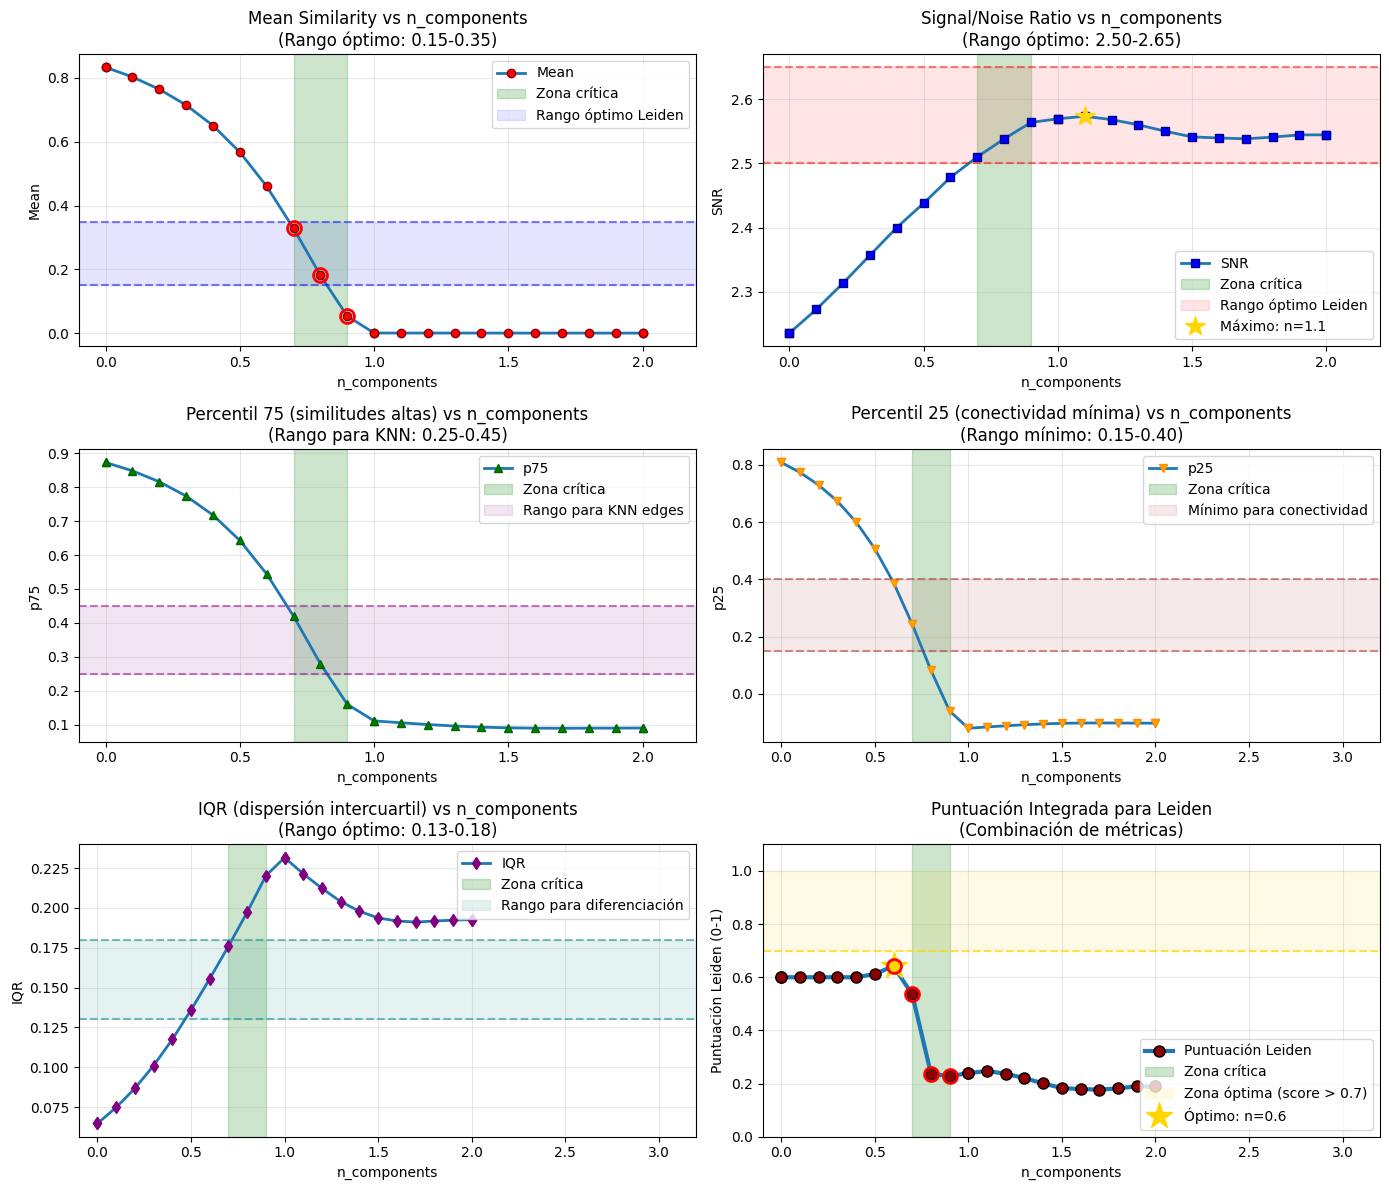

=== ANÁLISIS DE LA ZONA CRÍTICA (0.6-0.9) ===
    n_components      mean  signal_noise_ratio       p25       p75  score_leiden
9            0.6  0.460258            2.478308  0.388641  0.544170      0.641971
10           0.7  0.328224            2.510217  0.243610  0.419609      0.535151
11           0.8  0.181378            2.538348  0.082248  0.279517      0.237591
12           0.9  0.053654            2.564006 -0.060291  0.159884      0.228011

★ RECOMENDACIÓN FINAL: n = 0.6 (score: 0.642)


In [ ]:
# Usar tus datos (asumiendo que están en df)
n_values = df['n_components'].values
mean_values = df['mean'].values
snr_values = df['signal_noise_ratio'].values
p75_values = df['p75'].values
p25_values = df['p25'].values
iqr_values = df['iqr'].values

# Definir rangos óptimos basados en análisis para Leiden
RANGOS_OPTIMOS = {
    'mean': (0.15, 0.35),  # Ni muy alto (bias) ni muy bajo (pérdida señal)
    'signal_noise_ratio': (2.50, 2.65),  # Alto pero no extremo
    'p75': (0.25, 0.45),  # Buen umbral para edges en KNN
    'p25': (0.15, 0.40),  # Suficiente para conectividad mínima
    'iqr': (0.13, 0.18),  # Dispersión buena para diferenciación
}

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# 1. MEAN con franja óptima
ax = axes[0, 0]
ax.plot(n_values, mean_values, 'o-', linewidth=2, markersize=6, 
        markerfacecolor='red', markeredgecolor='darkred', label='Mean')
ax.axvspan(0.7, 0.9, alpha=0.2, color='green', label='Zona crítica')
# Franja óptima
ax.axhspan(RANGOS_OPTIMOS['mean'][0], RANGOS_OPTIMOS['mean'][1], 
           alpha=0.1, color='blue', label='Rango óptimo Leiden')
ax.axhline(y=RANGOS_OPTIMOS['mean'][0], color='blue', linestyle='--', alpha=0.5)
ax.axhline(y=RANGOS_OPTIMOS['mean'][1], color='blue', linestyle='--', alpha=0.5)
# Puntos de interés
for n in [0.7, 0.8, 0.9]:
    idx = np.where(n_values == n)[0][0]
    ax.plot(n, mean_values[idx], 'o', markersize=10, markerfacecolor='none', 
            markeredgecolor='red', markeredgewidth=2)
ax.set_title('Mean Similarity vs n_components\n(Rango óptimo: 0.15-0.35)')
ax.set_xlabel('n_components')
ax.set_ylabel('Mean')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
ax.set_xlim(-0.1, 2.2)

# 2. SIGNAL/NOISE RATIO con franja óptima
ax = axes[0, 1]
ax.plot(n_values, snr_values, 's-', linewidth=2, markersize=6,
        markerfacecolor='blue', markeredgecolor='darkblue', label='SNR')
ax.axvspan(0.7, 0.9, alpha=0.2, color='green', label='Zona crítica')
# Franja óptima
ax.axhspan(RANGOS_OPTIMOS['signal_noise_ratio'][0], RANGOS_OPTIMOS['signal_noise_ratio'][1],
           alpha=0.1, color='red', label='Rango óptimo Leiden')
ax.axhline(y=RANGOS_OPTIMOS['signal_noise_ratio'][0], color='red', linestyle='--', alpha=0.5)
ax.axhline(y=RANGOS_OPTIMOS['signal_noise_ratio'][1], color='red', linestyle='--', alpha=0.5)
# Máximo
max_idx = np.argmax(snr_values)
ax.plot(n_values[max_idx], snr_values[max_idx], '*', markersize=15, 
        color='gold', label=f'Máximo: n={n_values[max_idx]:.1f}')
ax.set_title('Signal/Noise Ratio vs n_components\n(Rango óptimo: 2.50-2.65)')
ax.set_xlabel('n_components')
ax.set_ylabel('SNR')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
ax.set_xlim(-0.1, 2.2)

# 3. P75 (umbral alto) con franja óptima
ax = axes[1, 0]
ax.plot(n_values, p75_values, '^-', linewidth=2, markersize=6,
        markerfacecolor='green', markeredgecolor='darkgreen', label='p75')
ax.axvspan(0.7, 0.9, alpha=0.2, color='green', label='Zona crítica')
# Franja óptima para KNN edges
ax.axhspan(RANGOS_OPTIMOS['p75'][0], RANGOS_OPTIMOS['p75'][1],
           alpha=0.1, color='purple', label='Rango para KNN edges')
ax.axhline(y=RANGOS_OPTIMOS['p75'][0], color='purple', linestyle='--', alpha=0.5)
ax.axhline(y=RANGOS_OPTIMOS['p75'][1], color='purple', linestyle='--', alpha=0.5)
ax.set_title('Percentil 75 (similitudes altas) vs n_components\n(Rango para KNN: 0.25-0.45)')
ax.set_xlabel('n_components')
ax.set_ylabel('p75')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
ax.set_xlim(-0.1, 2.2)

# 4. P25 (conectividad mínima) con franja óptima
ax = axes[1, 1]
ax.plot(n_values, p25_values, 'v-', linewidth=2, markersize=6,
        markerfacecolor='orange', markeredgecolor='darkorange', label='p25')
ax.axvspan(0.7, 0.9, alpha=0.2, color='green', label='Zona crítica')
# Franja crítica para conectividad
ax.axhspan(RANGOS_OPTIMOS['p25'][0], RANGOS_OPTIMOS['p25'][1],
           alpha=0.1, color='brown', label='Mínimo para conectividad')
ax.axhline(y=RANGOS_OPTIMOS['p25'][0], color='brown', linestyle='--', alpha=0.5)
ax.axhline(y=RANGOS_OPTIMOS['p25'][1], color='brown', linestyle='--', alpha=0.5)
ax.set_title('Percentil 25 (conectividad mínima) vs n_components\n(Rango mínimo: 0.15-0.40)')
ax.set_xlabel('n_components')
ax.set_ylabel('p25')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
ax.set_xlim(-0.1, 3.2)

# 5. IQR (dispersión) con franja óptima
ax = axes[2, 0]
ax.plot(n_values, iqr_values, 'd-', linewidth=2, markersize=6,
        markerfacecolor='purple', markeredgecolor='purple', label='IQR')
ax.axvspan(0.7, 0.9, alpha=0.2, color='green', label='Zona crítica')
# Franja óptima para diferenciación
ax.axhspan(RANGOS_OPTIMOS['iqr'][0], RANGOS_OPTIMOS['iqr'][1],
           alpha=0.1, color='teal', label='Rango para diferenciación')
ax.axhline(y=RANGOS_OPTIMOS['iqr'][0], color='teal', linestyle='--', alpha=0.5)
ax.axhline(y=RANGOS_OPTIMOS['iqr'][1], color='teal', linestyle='--', alpha=0.5)
ax.set_title('IQR (dispersión intercuartil) vs n_components\n(Rango óptimo: 0.13-0.18)')
ax.set_xlabel('n_components')
ax.set_ylabel('IQR')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
ax.set_xlim(-0.1, 3.2)

# 6. ZONA ÓPTIMA INTEGRADA
ax = axes[2, 1]
# Calcular puntuación compuesta
score_mean = np.clip((mean_values - 0.15) / (0.35 - 0.15), 0, 1)
score_snr = np.clip((snr_values - 2.50) / (2.65 - 2.50), 0, 1)
score_p75 = np.clip((p75_values - 0.25) / (0.45 - 0.25), 0, 1)
score_p25 = np.clip((p25_values - 0.15) / (0.40 - 0.15), 0, 1)
score_iqr = np.clip((iqr_values - 0.13) / (0.18 - 0.13), 0, 1)

# Ponderaciones según importancia para Leiden
pesos = {'mean': 0.2, 'snr': 0.3, 'p75': 0.2, 'p25': 0.2, 'iqr': 0.1}
score_total = (score_mean * pesos['mean'] + score_snr * pesos['snr'] + 
               score_p75 * pesos['p75'] + score_p25 * pesos['p25'] + 
               score_iqr * pesos['iqr'])

ax.plot(n_values, score_total, 'o-', linewidth=3, markersize=8,
        markerfacecolor='darkred', markeredgecolor='black', label='Puntuación Leiden')
ax.axvspan(0.7, 0.9, alpha=0.2, color='green', label='Zona crítica')

# Franja óptima (score > 0.7)
ax.axhspan(0.7, 1.0, alpha=0.1, color='gold', label='Zona óptima (score > 0.7)')
ax.axhline(y=0.7, color='gold', linestyle='--', alpha=0.7)

# Encontrar óptimos
optimal_idx = np.argmax(score_total)
ax.plot(n_values[optimal_idx], score_total[optimal_idx], '*', 
        markersize=20, color='gold', label=f'Óptimo: n={n_values[optimal_idx]:.1f}')

# Marcar puntos de interés
for n in [0.6, 0.7, 0.8, 0.9]:
    idx = np.where(np.abs(n_values - n) < 0.01)[0][0]
    ax.plot(n, score_total[idx], 'o', markersize=10, markerfacecolor='none',
            markeredgecolor='red', markeredgewidth=2)

ax.set_title('Puntuación Integrada para Leiden\n(Combinación de métricas)')
ax.set_xlabel('n_components')
ax.set_ylabel('Puntuación Leiden (0-1)')
ax.grid(True, alpha=0.3)
ax.legend(loc='lower right')
ax.set_xlim(-0.1, 3.2)
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

# Mostrar tabla de puntuaciones para la zona crítica
print("=== ANÁLISIS DE LA ZONA CRÍTICA (0.6-0.9) ===")
zona_critica = df[(df['n_components'] >= 0.6) & (df['n_components'] <= 0.9)].copy()
zona_critica['score_leiden'] = score_total[(n_values >= 0.6) & (n_values <= 0.9)]

print(zona_critica[['n_components', 'mean', 'signal_noise_ratio', 'p25', 'p75', 'score_leiden']].to_string())
print(f"\n★ RECOMENDACIÓN FINAL: n = {n_values[optimal_idx]:.1f} (score: {score_total[optimal_idx]:.3f})")

In [ ]:
k_apox_1 = np.log2(len(embeddings))
k_apox_2 = np.sqrt(len(embeddings))
print(k_apox_1)
print(k_apox_2)

In [ ]:
Embeddings_SIF = sif_all_but_the_top_vectorized(embeddings=embeddings, n_components=0.7)
# Verificar calidad de embeddings post-SIF
print(f"Embeddings shape: {Embeddings_SIF.shape}")
print(f"Normas después de L2: {np.linalg.norm(Embeddings_SIF, axis=1)[:5]}")
print(f"Similaridad promedio entre primeros 30000 documentos: {cosine_similarity(Embeddings_SIF[:30000]).mean():.4f}")

In [ ]:
# Examinar densidad y distribución de pesos
W = build_knn_sparse(Embeddings_SIF, k=15)
print(f"Densidad del grafo: {W.nnz / (W.shape[0]**2):.6f}")
print(f"Distribución de pesos: min={W.data.min():.3f}, "
      f"mediana={np.median(W.data):.3f}, max={W.data.max():.3f}")

In [ ]:
# Simple implementation

ks = 60

W = build_knn_sparse (
    Embeddings,     # Optional Embeddings_SIF
    k = ks, 
    metric = "cosine", 
    n_jobs = -1
    )
G = scipy_to_igraph (W)

labels_LEIDEN, partition_LEIDEN = run_leiden_robust(
    G, 
    resolution = 5,
    n_iterations = 1,
    seed = 42
    )

## 3.3 LEIDEN EXPERIMENTS

In [13]:
def compute_semantic_centroids (Embeddings, labels):
    centroids = {}
    for t in np.unique(labels):
        mask = (labels == t)
        centroids[t] = Embeddings[mask].mean(axis=0)
    return centroids

In [14]:
def cluster_sizes (labels):
    cnt = Counter(labels)
    sizes = np.array(list(cnt.values()), dtype=int)
    return sizes

def max_share (labels):
    sizes = cluster_sizes(labels)
    N = sizes.sum()
    return sizes.max() / N

def gini_of_sizes (labels, eps=1e-9):
    x = cluster_sizes(labels).astype(float)
    x = np.sort(x)
    n = x.size
    if n == 0:
        return np.nan
    return (2.0 * np.sum((np.arange(1 , n+1) * x)) /(n * (x.sum() + eps))) - (n + 1) / n

def comprehensive_cluster_metrics(labels, embeddings = None, graph = None):

    sizes = cluster_sizes(labels)
    n_clusters = len(sizes)
    n_docs = len(labels)

    metrics = {
        'n_clusters': n_clusters,
        'n_singletons': np.sum(sizes == 1),
        'max_cluster_size': sizes.max(),
        'min_cluster_size': sizes.min(),
        'avg_cluster_size': sizes.mean(),
        'max_share': max_share(labels),
        'gini': gini_of_sizes(labels),
        'size_std': sizes.std()
    }
    
    # Silueta si tenemos embeddings
    if embeddings is not None and n_clusters > 1:
        from sklearn.metrics import silhouette_score
        try:
            # Muestrear para eficiencia si hay muchos datos
            if n_docs > 10000:
                sample_idx = np.random.choice(n_docs, 10000, replace=False)
                sample_emb = embeddings[sample_idx]
                sample_labels = labels[sample_idx]
            else:
                sample_emb = embeddings
                sample_labels = labels
            
            metrics['silhouette'] = silhouette_score(sample_emb, sample_labels, metric='cosine')
        except:
            metrics['silhouette'] = -1
    else:
        metrics['silhouette'] = -1
    
    # Modularidad si tenemos el grafo
    if graph is not None and graph.ecount() > 0:
        try:
            partition = leidenalg.RBConfigurationVertexPartition(graph, weights=graph.es['weight'])
            partition.membership = labels.tolist()
            metrics['modularity'] = partition.quality()
        except:
            metrics['modularity'] = -1
    else:
        metrics['modularity'] = -1
    
    return metrics

In [15]:
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

def add_scientific_metrics(labels, embeddings,
                           sample_size=12000,
                           per_cluster_cap=600,
                           seed=42,
                           coverage_threshold=0.7,
                           coverage_min_cluster_size=30):
    """
    Safe scientific metrics for large N.
    - silhouette: sample (as you already do)
    - calinski_harabasz / davies_bouldin: sample (otherwise too heavy at 100k)
    - coverage_0.7: capped per cluster + only for sufficiently large clusters
    """
    from sklearn.metrics import (
        silhouette_score,
        calinski_harabasz_score,
        davies_bouldin_score
    )

    X = np.asarray(embeddings, dtype=np.float32)
    y = np.asarray(labels)

    metrics = {}
    uniq = np.unique(y)
    if uniq.size <= 1:
        # single cluster => undefined
        metrics["silhouette"] = -1
        metrics["calinski_harabasz"] = -1
        metrics["davies_bouldin"] = float("inf")
        metrics["coverage_0.7"] = -1
        metrics["sci_sample_n"] = 0
        return metrics

    rng = np.random.default_rng(seed)

    # ---------- Build a stratified sample for global metrics (sil/CH/DB) ----------
    idxs = []
    for c in uniq:
        members = np.where(y == c)[0]
        if members.size == 0:
            continue
        take = min(per_cluster_cap, members.size)
        idxs.append(rng.choice(members, size=take, replace=False))
    idx = np.concatenate(idxs) if idxs else rng.choice(np.arange(len(y)), size=min(sample_size, len(y)), replace=False)

    if idx.size > sample_size:
        idx = rng.choice(idx, size=sample_size, replace=False)

    Xs = X[idx]
    ys = y[idx]
    metrics["sci_sample_n"] = int(idx.size)

    # ---------- 1) Silhouette (cosine) ----------
    try:
        metrics["silhouette"] = float(silhouette_score(Xs, ys, metric="cosine"))
    except Exception:
        metrics["silhouette"] = -1

    # ---------- 2) Calinski-Harabasz (sampled) ----------
    # Note: CH is Euclidean-based; still ok as heuristic on embeddings.
    try:
        metrics["calinski_harabasz"] = float(calinski_harabasz_score(Xs, ys))
    except Exception:
        metrics["calinski_harabasz"] = -1

    # ---------- 3) Davies-Bouldin (sampled) ----------
    try:
        metrics["davies_bouldin"] = float(davies_bouldin_score(Xs, ys))
    except Exception:
        metrics["davies_bouldin"] = float("inf")

    # ---------- 4) Coverage (Amigó et al., 2009-inspired) ----------
    # We compute: for each (large-enough) cluster, fraction of points with cos(sim) to centroid > threshold.
    # Use caps to avoid heavy loops with many microclusters.
    try:
        # normalize once for cosine via dot
        Xn = normalize(X, norm="l2")
        coverage_scores = []
        for c in uniq:
            members = np.where(y == c)[0]
            if members.size < coverage_min_cluster_size:
                continue  # skip microclusters to avoid huge loop count + noise
            # cap per cluster
            if members.size > per_cluster_cap:
                members = rng.choice(members, size=per_cluster_cap, replace=False)

            # centroid on normalized vectors (stable)
            centroid = Xn[members].mean(axis=0)
            # normalize centroid
            centroid /= (np.linalg.norm(centroid) + 1e-12)

            sims = Xn[members] @ centroid  # fast cosine similarity
            coverage_scores.append(float(np.mean(sims > coverage_threshold)))

        metrics["coverage_0.7"] = float(np.mean(coverage_scores)) if coverage_scores else -1
    except Exception:
        metrics["coverage_0.7"] = -1

    return metrics


In [16]:
def optimize_memory_usage(details, keep_full_data=False):
    """Reduce memoria manteniendo información esencial"""
    optimized_details = {}
    
    for config, data in details.items():
        if keep_full_data:
            # Mantener todo para análisis posterior
            optimized_details[config] = data
        else:
            # Solo métricas agregadas (90% menos memoria)
            optimized_details[config] = {
                'm1_summary': data['first_mesure'].describe().to_dict(),
                'm3_summary': data['third_mesure'].describe().to_dict(),
                'cluster_sizes': cluster_sizes(data['labels']),
                # No guardar labels a menos que sea necesario
                # 'labels': data['labels']  
            }
    
    return optimized_details

In [17]:
def scientific_scoring(df_summary):
    """Sistema de scoring con base científica sólida"""
    return (
        + 2.0 * df_summary["m1_margin_mean"]           # Separación (Silhouette-like)
        + 1.5 * df_summary["m3_cos_mean_w"]            # Cohesión (Purity)
        - 1.0 * df_summary["m3_share_below_0.6_w"]     # Calidad mínima
        - 0.5 * (df_summary["small_leq_10"] / df_summary["n_clusters"].clip(lower=1))  # Fragmentación
        + 1.0 * df_summary.get("silhouette", 0)        # Métrica establecida
        - 0.3 * df_summary.get("davies_bouldin", 0)    # Compactness vs Separation
    )

In [18]:
# FIRST MESURE
# INTER topics vs ENTRE topics - FAST VERSION

def cluster_separation_fast (Embeddings, labels):
    """
    First mesure
     - intra_mean_doc_centroid
     - intra_p10_doc_centroid
     - inter_mean_doc_centroid
     - inter_max_doc_centroid
     margin_vs_intr_max = intra_mean - inter_max (≥0 no desirable)
    """
    centroids = compute_semantic_centroids(Embeddings, labels)
    cols = ["topic","n_docs",
            "intra_mean_doc_centroid",
            "intra_p10_doc_centroid",
            "inter_mean_doc_centroid",
            "inter_max_doc_centroid",
            "margin_vs_inter_max"]
    if not centroids:
        return pd.DataFrame(columns=cols)

    topics = sorted (centroids.keys())
    MU = np.vstack ([centroids [t] for t in topics])
    MU_norm = MU / np.linalg.norm(MU, axis=1, keepdims=True)
    S_cc = MU_norm @ MU_norm.T
    np.fill_diagonal (S_cc, -1)

    rows = []
    for t in topics:
        mask = (labels == t)
        X = Embeddings[mask]
        MU_t = centroids[t][None, :]
        intra_cos = cosine_similarity (X, MU_t)[:, 0]
        inter_mean = S_cc[topics.index(t)].mean() if len(topics) > 1 else -1.0
        inter_max = S_cc[topics.index(t)].max() if len(topics) >1 else -1.0
        rows.append ({
            "topic": t,
            "n_docs": int(mask.sum()),
            "intra_mean_doc_centroid": float(intra_cos.mean()),
            "intra_p10_doc_centroid": float(np.percentile(intra_cos, 10)),
            "inter_mean_doc_centroid": float(inter_mean),
            "inter_max_doc_centroid": float(inter_max),
            "margin_vs_inter_max": float(intra_cos.mean() - inter_max)
        })

    return pd.DataFrame(rows).sort_values("margin_vs_inter_max")

In [19]:
# THIRD MESURE
# COVERAGE vs PURITY

def coverage_purity (Embeddings, labels, thresholds = (0.5, 0.6, 0.7)):
    centroids = compute_semantic_centroids(Embeddings, labels)
    cols = ["topic",
            "n_docs",
            "cos_mean",
            "cos_p10",
            "cos_p50",
            "cos_p90"] + \
            [f"share_beloww_{th:.1f}" for th in thresholds]
    if not centroids:
        return pd.DataFrame(columns=cols)
    
    rows = []
    for t, mu in centroids.items():
        mask = (labels == t)
        X = Embeddings[mask]
        sims = cosine_similarity(X, mu[None, :])[:, 0]
        row = {
            "topic": t,
            "n_docs": int(mask.sum()),
            "cos_mean": float(sims.mean()),
            "cos_p10": float(np.percentile(sims, 10)),
            "cos_p50": float(np.percentile(sims, 50)),
            "cos_p90": float(np.percentile(sims, 90)),
        }
        for th in thresholds:
            row[f"share_below_{th:.1f}"] = float((sims < th).mean())
        rows.append(row)
    return pd.DataFrame(rows, columns= cols).sort_values("cos_mean")

In [20]:
# LEIDEN with GRAPH K_NN Second Experiment
# Experiment to assest the "Intra vs Inter Topics" & "Coverage vs Purity"

def summarize_sizes (labels):
    """Cluster size distribution for a given label"""
    vc = pd.Series(labels).value_counts().sort_values(ascending=False)
    return {
        "n_clusters": int(vc.shape[0]),
        "largest": int(vc.iloc[0]),
        "median_size": int(vc.median()),
        "small_leq_10": int((vc <= 10).sum())
    }

def summarize_m1 (df_m1):
    return {
        "m1_margin_mean": float(df_m1["margin_vs_inter_max"].mean()),
        "m1_margin_p10": float(df_m1["margin_vs_inter_max"].quantile(0.10)),
        "m1_intra_mean": float(df_m1["intra_mean_doc_centroid"].mean()),
        "m1_inter_max_mean": float(df_m1["inter_max_doc_centroid"].mean())
    }

def summarize_m3 (df_m3):
    w = df_m3["n_docs"].clip(lower=1)       # Avoid division by zero
    w = w / w.sum()                         # Average ponderatrion by size
    out = {
        "m3_cos_mean_w": float((df_m3["cos_mean"] * w).sum()),
        "m3_cos_p50_w": float((df_m3["cos_p50"] * w).sum()),
        "m3_share_below_0.6_w": float((df_m3.get("share_below_0.6", 0) * w).sum()),
        "m3_share_below_0.7_w": float((df_m3.get("share_below_0.7", 0) * w).sum()),
    }
    out ["m3_cos_mean_min"] = float (df_m3["cos_mean"].min())
    return out


In [21]:
# Requires:
# - build_knn_sparse_optimized(...)
# - scipy_to_igraph_light(...)  (sin enforce_connectivity)
# - run_leiden_one_robust(...)  (la versión robusta “una resolución”)
# - cluster_separation_fast(...), coverage_purity(...), max_share(...), gini_of_sizes(...)
# - summarize_sizes(...), summarize_m1(...), summarize_m3(...)
# - add_scientific_metrics(...)


def compare_configs_leiden(
    Embeddings,
    configs=((40, 6.0), (40, 7.0)),
    seed=42,
    save_prefix="COMPARE_LEIDEN",
    # Robust Leiden
    n_restarts=3,
    n_iterations=2,
    # kNN / graph
    knn_jobs=8,
    knn_similarity_threshold="auto",
    ig_weight_threshold="auto",
    ig_min_weight_quantile=0.75,
    # IO / memory
    store_details=False,          # << default False: evita guardar df grandes
    save_details=False,
    verbose_graph=True,
    verbose_igraph=True,
    # Debug
    debug_checkpoints=True,       # << imprime etapa exacta
):
    """
    Robust + safer compare loop.
    Key changes:
      - uses run_leiden_one_robust (single resolution, restarts)
      - does NOT store big dfs in details unless store_details=True
      - checkpoint prints to locate crash stage
      - forces float32 embeddings to reduce peaks and avoid weird broadcasting
    """
    # ---- 0) Sanity & types ----
    X = np.asarray(Embeddings, dtype=np.float32)
    if X.ndim != 2:
        raise ValueError(f"Embeddings must be 2D array, got shape={X.shape}")
    N, D = X.shape
    if debug_checkpoints:
        print(f"[DEBUG] Embeddings shape: N={N}, D={D}, dtype={X.dtype}")

    if len(configs) == 0:
        raise ValueError("configs is empty")

    out_dir = os.path.dirname(save_prefix)
    if out_dir:
        os.makedirs(out_dir, exist_ok=True)

    # ---- 1) Build graph per k (store only G to avoid memory peaks) ----
    ks = sorted(set(int(k) for k, _ in configs))
    graphs_by_k = {}

    for k in ks:
        if debug_checkpoints:
            print(f"[DEBUG] Stage: build_graph k={k}")
        W = build_knn_sparse_optimized(
            X, k=int(k), metric="cosine",
            similarity_threshold=knn_similarity_threshold,
            symmetrization="max",
            n_jobs=knn_jobs,
            verbose=verbose_graph
        )

        if debug_checkpoints:
            print(f"[DEBUG] Stage: to_igraph k={k} (W.nnz={W.nnz})")
        G = scipy_to_igraph_light(
            W,
            weight_threshold=ig_weight_threshold,
            min_weight_quantile=ig_min_weight_quantile,
            verbose=verbose_igraph
        )

        graphs_by_k[int(k)] = G

        # free W aggressively
        del W
        gc.collect()

    # ---- 2) Iterate configs ----
    summary_rows = []
    details = {}

    for idx_cfg, (k, res) in enumerate(configs):
        k = int(k)
        res = float(res)
        G = graphs_by_k[k]

        if debug_checkpoints:
            print(f"[DEBUG] Stage: leiden (k={k}, res={res})")

        labels, part, meta = run_leiden_one_robust(
            G, resolution=res,
            n_restarts=int(n_restarts),
            seed=seed,
            n_iterations=int(n_iterations)
        )

        meta_clean = {
            "n_clusters": int(meta.get("n_clusters", -1)),
            "largest": int(meta.get("largest", -1)),
            "median_size": int(meta.get("median_size", -1)),
            "small_leq_10": int(meta.get("small_leq_10", -1)),
            "modularity_like": float(meta.get("quality", np.nan)),
        }

        # ---- Metrics block with checkpoints ----
        if debug_checkpoints:
            print(f"[DEBUG] Stage: sizes (k={k}, res={res})")
        sizes_sum = summarize_sizes(labels)
        max_share_val = float(max_share(labels))
        gini_sizes_val = float(gini_of_sizes(labels))

        # m1
        if debug_checkpoints:
            print(f"[DEBUG] Stage: m1 cluster_separation_fast (k={k}, res={res})")
        df_m1 = cluster_separation_fast(X, labels)
        m1_sum = summarize_m1(df_m1)

        # m3
        if debug_checkpoints:
            print(f"[DEBUG] Stage: m3 coverage_purity (k={k}, res={res})")
        df_m3 = coverage_purity(X, labels, thresholds=(0.5, 0.6, 0.7))
        m3_sum = summarize_m3(df_m3)

        # scientific metrics
        if debug_checkpoints:
            print(f"[DEBUG] Stage: scientific add_scientific_metrics (k={k}, res={res})")
        scientific_metrics = add_scientific_metrics(labels, X)

        row = {
            "k": k,
            "resolution": res,
            # leiden meta
            **meta_clean,
            # summaries
            **sizes_sum,
            **m1_sum,
            **m3_sum,
            "max_share": max_share_val,
            "gini": gini_sizes_val,
            **scientific_metrics,
        }
        summary_rows.append(row)

        # Store minimal details unless explicitly requested
        if store_details:
            details[(k, res)] = {
                "labels": labels,
                "partition": part,
                "meta": meta_clean,
                "first_mesure": df_m1,
                "third_mesure": df_m3
            }
        else:
            details[(k, res)] = {"meta": meta_clean}  # mínimo

        # Optional saving of heavy dfs (off by default)
        if save_details:
            df_m1.to_csv(f"{save_prefix}_M1_K{k}_res{res}.csv", index=False)
            df_m3.to_csv(f"{save_prefix}_M3_K{k}_res{res}.csv", index=False)

        # free big objects each loop
        del labels, part, df_m1, df_m3, scientific_metrics
        gc.collect()

        # periodic GC
        if (idx_cfg + 1) % 5 == 0:
            gc.collect()

    df_summary = (
        pd.DataFrame(summary_rows)
        .sort_values(["k", "resolution"])
        .reset_index(drop=True)
    )
    df_summary.to_csv(f"{save_prefix}_SUMMARY.csv", index=False)

    # ---- Ranking (safe get) ----
    df_rank = (
        df_summary
        .assign(
            score=(
                + 2.0 * df_summary.get("m1_margin_mean", 0)
                + 1.5 * df_summary.get("m3_cos_mean_w", 0)
                - 0.8 * df_summary.get("m3_share_below_0.6_w", 0)
                - 0.2 * (df_summary.get("small_leq_10", 0) / df_summary.get("n_clusters", 1).clip(lower=1))
                + 1.0 * df_summary.get("silhouette", 0)
                - 0.3 * df_summary.get("davies_bouldin", 0)
            )
        )
        .sort_values("score", ascending=False)
        .reset_index(drop=True)
    )
    df_rank.to_csv(f"{save_prefix}_RANK.csv", index=False)

    print("\n=== TOP 5 CONFIGS (composed score) ===")
    cols = [c for c in [
        "k","resolution","n_clusters","largest","median_size","small_leq_10",
        "m1_margin_mean","m3_cos_mean_w","m3_share_below_0.6_w","max_share","gini",
        "silhouette","calinski_harabasz","score"
    ] if c in df_rank.columns]
    print(df_rank.head(5)[cols])

    return df_summary, details, df_rank



## 3.4 Experiment Implementation

In [23]:
# Second Experiment implementation
from itertools import product
ks= (10, 15, 20, 25, 30, 50)
resolutions=(0.1, 0.5, 1, 2, 3, 5, 8, 10, 11, 12, 14, 16, 18, 20)

Configs = list(product(ks, resolutions))
print (len(Configs))
print (Configs[:5])

84
[(10, 0.1), (10, 0.5), (10, 1), (10, 2), (10, 3)]


In [24]:
n_comp = 0.70

for i in range (2,5):
    print(f"Working on: {DIR[1][i]}")

    Embeddings  = pd.read_parquet(DIR[0][i])["chunk_emb"].tolist()
    Texts       = pd.read_parquet(DIR[0][i])["chunk_text"].tolist()

    Embeddings_SIF = sif_all_but_the_top_vectorized(embeddings=Embeddings, n_components=n_comp)

    df_summary, details, df_rank = compare_configs_leiden(
    Embeddings  = Embeddings_SIF,
    configs     = Configs,   # tuples (k, res)
    seed        = 42,
    save_prefix = f"04_Emb & K_Selection/COMPARE_LEIDEN_{DIR[1][i]}_COMP_{n_comp}",
    # Robust Leiden
    n_restarts  = 3,
    n_iterations= 2,
    # kNN / graph
    knn_jobs    = 8,
    knn_similarity_threshold    = "auto",
    ig_weight_threshold         = "auto",
    ig_min_weight_quantile      = 0.65,
    # IO
    save_details                = False,
    verbose_graph               = True,
    verbose_igraph              = True
    )

    print(f"{DIR[1][i]} done")


Working on: TEST_EMB_HARD
[DEBUG] Embeddings shape: N=100044, D=768, dtype=float32
[DEBUG] Stage: build_graph k=10
Building KNN graph: N=100044, k=10, metric=cosine
  Auto-threshold (kNN sims): q25=0.671 (mean=0.710, median=0.709)
  Result: edges=553361, density=0.00011058, mean_degree≈11.06
  Edge weights: mean=0.729, min=0.671, max=1.000
[DEBUG] Stage: to_igraph k=10 (W.nnz=1106723)
Converting to igraph: nnz=1106723, N=100044
  Weight stats (raw): mean=0.729, median=0.722, p75=0.754
  Using threshold=0.754 => V=100044, E=137618, components=51791
  Weight stats (kept): mean=0.789, min=0.754, max=1.000
[DEBUG] Stage: build_graph k=15
Building KNN graph: N=100044, k=15, metric=cosine
  Auto-threshold (kNN sims): q25=0.661 (mean=0.700, median=0.699)
  Result: edges=829887, density=0.00016583, mean_degree≈16.59
  Edge weights: mean=0.719, min=0.661, max=1.000
[DEBUG] Stage: to_igraph k=15 (W.nnz=1659775)
Converting to igraph: nnz=1659775, N=100044
  Weight stats (raw): mean=0.719, median=

In [ ]:
Embeddings_SIF = sif_all_but_the_top_vectorized(embeddings=Embeddings, n_components=0.65)

W = build_knn_sparse_optimized(Embeddings_SIF, k=30, metric="cosine",
                               similarity_threshold="auto",
                               symmetrization="max", n_jobs=8, verbose=True)
print(W.shape, W.nnz, W.dtype)


In [ ]:
G = scipy_to_igraph_light(W, weight_threshold="auto", min_weight_quantile=0.75, verbose=True)
print(G.vcount(), G.ecount())

In [ ]:
labels, part, meta = run_leiden_one_robust(G, resolution=5.0, n_restarts=3, seed=42, n_iterations=2)
print(meta)


In [ ]:
import numpy as np, scipy
import igraph, leidenalg
print("numpy", np.__version__)
print("scipy", scipy.__version__)
print("igraph", igraph.__version__)
print("leidenalg", leidenalg.__version__)


## 3.5 LEIDEN ANALYSE OF RESULTS

In [ ]:
df_0 = pd.read_csv(f"04_Tests/{DIR[1][0]}_SUMMARY.csv")
df_0["emb_family"] = DIR[1][0]

df_1 = pd.read_csv(f"04_Tests/{DIR[1][1]}_SUMMARY.csv")
df_1["emb_family"] = DIR[1][1]

df_2 = pd.read_csv(f"04_Tests/{DIR[1][2]}_SUMMARY.csv")
df_2["emb_family"] = DIR[1][2]

df_3 = pd.read_csv(f"04_Tests/{DIR[1][3]}_SUMMARY.csv")
df_3["emb_family"] = DIR[1][3]

df_4 = pd.read_csv(f"04_Tests/{DIR[1][4]}_SUMMARY.csv")
df_4["emb_family"] = DIR[1][4]

df_5 = pd.read_csv(f"04_Tests/{DIR[1][5]}_SUMMARY.csv")
df_5["emb_family"] = DIR[1][5]

df_6 = pd.read_csv(f"04_Tests/{DIR[1][6]}_SUMMARY.csv")
df_6["emb_family"] = DIR[1][6]

df_7 = pd.read_csv(f"04_Tests/{DIR[1][7]}_SUMMARY.csv")
df_7["emb_family"] = DIR[1][7]


In [ ]:
TEST_df = pd.concat([df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7],
               ignore_index=True
               )
TEST_df["small_leq_10_pc"] = TEST_df["small_leq_10"] / TEST_df["n_clusters"]
display(TEST_df)

### 3.5.1 EMBEDDINGS SELECTION

In [ ]:
TEST_df = pd.concat([df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7],
               ignore_index=True
               )
TEST_df["small_leq_10_pc"] = TEST_df["small_leq_10"] / TEST_df["n_clusters"]
display(TEST_df)

# POST METRICS

# Metrics to maximize
metrics_pos =[
    "m1_margin_mean",
    "silhouette",
    "calinski_harabasz",
    "coverage_0.7",
    "m3_cos_mean_min"
]

# Metrics to minimize
metrics_neg =[
    "davies_bouldin",
    "gini"
]
small_10 = [
    "small_leq_10_pc"
]

metrics_all = metrics_pos + metrics_neg + small_10

In [ ]:
# 1. Normalization [0,1]
TEST_norm = TEST_df.copy()

for m in metrics_pos:
    TEST_norm[m+"_norm"] = (TEST_df[m] - TEST_df[m].min()) / (TEST_df[m].max() - TEST_df[m].min())

for m in metrics_neg:
    tmp = (TEST_df[m] - TEST_df[m].min()) / (TEST_df[m].max() - TEST_df[m].min())
    TEST_norm[m+"_norm"] = 1 - tmp

for m in small_10:
    min_10 = 0.03
    max_10 = 0.10

    TEST_norm[m+"_norm"] = np.where (
        TEST_df[m] > max_10,
        0,
        np.where (
            TEST_df[m] <= min_10,
            1,
            1 - ((TEST_df[m] - min_10) / (max_10 - min_10))
        )
    )

# 2. Compossed index
weights = {m+"_norm": 1 for m in metrics_all}

def compute_Q (row):
    return sum(row[m] * w for m, w in weights.items())

TEST_norm["Q"] = TEST_norm.apply(compute_Q, axis=1)

In [ ]:
TEST_df.to_clipboard()
display(TEST_norm)

In [ ]:
# Stability metric (stab)

def stability_metric (group, col):
    mean = group[col].mean()
    std = group[col].std()
    cv = std / (mean + 1e-9)
    return 1 / (1 + cv)

stab_results = (
    TEST_norm.groupby(["emb_family", "k"])
    .apply(lambda g: {m+"_stab": stability_metric(g, m+"_norm") for m in metrics_all})
    .apply(pd.Series)
    .reset_index()
    )
display(stab_results)

In [ ]:
# Quality-Stability Index S(e,k)

Q_stats = TEST_norm.groupby(["emb_family", "k"])["Q"].agg(["mean", "std"]).reset_index()
Q_stats.rename(columns={"mean": "Q_mean", "std": "Q_std"}, inplace=True)

Q_stats["S_e_k"] = Q_stats["Q_mean"] / (1 + Q_stats["Q_std"])

Q_stats.to_clipboard()
display(Q_stats)

In [ ]:
# Global index

def p90(x):
    return x.quantile(0.9)

ranking_emb = (
    Q_stats.
    groupby("emb_family")["S_e_k"]
    .agg(
        Q_mean = "median",
        Q_p90 = p90,
        Q_std = "std"
    )
    .reset_index()
)

ranking_emb["potential"] = ranking_emb["Q_p90"] - ranking_emb["Q_mean"]
ranking_emb["Total"] = (
    ranking_emb["Q_mean"] + 
    ranking_emb["potential"] -
    ranking_emb["Q_std"]
)

ranking_emb = ranking_emb.sort_values("Total", ascending = False)

display(ranking_emb)

#### GRAPHICS EMBEDDINGS

In [ ]:
#### Global configuration

# Style for paper

mpl.rcParams.update({
    "figure.dpi"        : 150,
    "figure.figsize"    : (8, 5),
    "font.size"         : 11,
    "axes.labelsize"    : 11,
    "axes.titlesize"    : 12,
    "xtick.labelsize"   : 9,
    "ytick.labelsize"   : 9,
    "legend.fontsize"   : 9,
    "axes.spines.top"   : False,
    "axes.spines.right" : False    
    })

emb_order = ranking_emb.sort_values("Total", ascending=False)["emb_family"].tolist()

all_SeK = Q_stats["S_e_k"].values
ymin, ymax = all_SeK.min() - 0.1, all_SeK.max() +0.1

data = [Q_stats[Q_stats["emb_family"] == emb] ["S_e_k"].values
        for emb in emb_order]

In [ ]:
# 1.A.  VIOLIN PLOT (PAPER) 👍🏼👍🏼

fig, ax = plt.subplots()

# Basic violin
parts = ax.violinplot (
    data,
    positions = np.arange(len(emb_order)),
    showmeans = False,
    showmedians = False,
    showextrema = False
)

# Adjust transparency (optional)
for pc in parts['bodies']:
    pc.set_alpha(0.4)

# Statistic values
medians = [np.median(d) for d in data]
means   = [np.mean(d) for d in data]

xpos = np.arange(len(emb_order))

# Line and median
for x, vals in zip(xpos, data):
    q1, q3 = np.percentile (vals, [25, 75])
    ax.vlines (x, q1, q3, linewidth=1)
    ax.hlines (medians[x], x - 0.1, x + 0.1, linewidth=1)

# Mean as a point
ax.scatter (xpos, means, marker="o", s=15, zorder=3)

ax.set_xticks(xpos)
ax.set_xticklabels(emb_order, rotation=45, ha="right")

ax.set_ylabel(r"$S_{e,k}$ (quality-stability index)")
ax.set_ylim(ymin, ymax)
ax.set_title(r"$S_{e,k}$ distribution by family of embeddings")

ax.grid(axis="y", linestyle="--", alpha=0.3)

fig.tight_layout()
plt.show()

In [ ]:
# 2.A BOXPLOT PAPER 👍🏼👍🏼

fig, ax = plt.subplots()

# Boxplot with means
bp = ax.boxplot(
    data,
    positions = np.arange(len(emb_order)),
    showmeans = True,
    meanline = False,
    widths = 0.6
)

# Make the lines thiner (Optional)
for element in ['boxes', 'whiskers', 'caps', 'medians', 'means']:
    for line in bp[element]:
        line.set_color("navy")
        line.set_linewidth(0.6)

ax.set_xticks (np.arange(len(emb_order)))
ax.set_xticklabels (emb_order, rotation=45, ha="right")

ax.set_ylabel (r"$S_{e, k}$ (quality-stability index)")
ax.set_ylim (ymin, ymax)
ax.set_title (r"$S_{e, k}$ by family of embeddings")

ax.grid (axis="y", linestyle="--", alpha=0.3)

fig.tight_layout()
plt.show()

In [ ]:
# 3.A. SCATTER "QUALITY vs STABILITY" (PAPER) 👍🏼👍🏼

fig, ax = plt.subplots()

x = ranking_emb["Q_std"].values
y = ranking_emb["Q_mean"].values
labels = ranking_emb["emb_family"].tolist()

ax.scatter (x, y, s=35)

for xi, yi, lab in zip(x, y, labels):
    ax.text(
        xi + 0.002, yi + 0.005, lab,
        fontsize=8, va="bottom", ha="left"
    )

ax.set_xlabel (r"$\mathrm{std}(S_{e, k})$ (stability - lower is better)")
ax.set_ylabel (r"$\mathrm{median}(S_{e, k})$ (base quality - higher is better)")
ax.set_title ("Quality vs stability by embeddings family")

x_margin = (x.max() - x.min()) * 0.15
y_margin = (x.max() - x.min()) * 0.10
ax.set_xlim(x.min() - x_margin, x.max() + x_margin)
ax.set_ylim(y.min() - y_margin, y.max() + y_margin)

ax.grid(True, linestyle="--", alpha=0.3)

fig.tight_layout()
plt.show()

In [ ]:
# 4. BEESWARM / STRIPPLOT

plt.figure (figsize = (8, 5))

for i , emb in enumerate (emb_order):
    sub = Q_stats[Q_stats["emb_family"] == emb]["S_e_k"].values
    # Jitter in x axe
    x = np.random.normal(loc=i+1, scale=0.04, size=len(sub))
    plt.scatter(x, sub, alpha=0.6, s=20)

plt.xticks (
    ticks = np.arange(1, len(emb_order) + 1),
    labels = emb_order,
    rotation = 45,
    ha = "right"
)

plt.ylabel ("S_e_k")
plt.title ("S_e_k distribution by embedding (beeswarm)")
plt.grid (True, linestyle="--", alpha = 0.4)
plt.tight_layout()
plt.show()

### 3.5.2 K SELECTION

In [ ]:
TEST_df_k = pd.concat([df_2, df_4, df_6],
               ignore_index=True
               )
TEST_df_k["small_leq_10_pc"] = TEST_df_k["small_leq_10"] / TEST_df_k["n_clusters"]
display(TEST_df_k)


# POST METRICS

# Metrics to maximize
metrics_pos =[
    "m1_margin_mean",
    "silhouette",
    "calinski_harabasz",
    "coverage_0.7",
    "m3_cos_mean_min"
]

# Metrics to minimize
metrics_neg =[
    "davies_bouldin",
    "gini"
]
small_10 = [
    "small_leq_10_pc"
]

metrics_all = metrics_pos + metrics_neg + small_10

In [ ]:
# 1. Normalization [0,1]
TEST_norm_k = TEST_df_k.copy()

for m in metrics_pos:
    TEST_norm_k[m+"_norm"] = (TEST_df_k[m] - TEST_df_k[m].min()) / (TEST_df_k[m].max() - TEST_df_k[m].min())

for m in metrics_neg:
    tmp = (TEST_df_k[m] - TEST_df_k[m].min()) / (TEST_df_k[m].max() - TEST_df_k[m].min())
    TEST_norm_k[m+"_norm"] = 1 - tmp

for m in small_10:
    min_10 = 0.03
    max_10 = 0.10

    TEST_norm_k[m+"_norm"] = np.where (
        TEST_df_k[m] > max_10,
        0,
        np.where (
            TEST_df_k[m] <= min_10,
            1,
            1 - ((TEST_df_k[m] - min_10) / (max_10 - min_10))
        )
    )

# 2. Compossed index
weights = {m+"_norm": 1 for m in metrics_all}

def compute_Q (row):
    return sum(row[m] * w for m, w in weights.items())

TEST_norm_k["Q"] = TEST_norm_k.apply(compute_Q, axis=1)

display(TEST_norm_k)

In [ ]:
# Stability metric (stab)

def stability_metric (group, col):
    mean = group[col].mean()
    std = group[col].std()
    cv = std / (mean + 1e-9)
    return 1 / (1 + cv)

stab_results_k = (
    TEST_norm_k.groupby(["emb_family", "k"])
    .apply(lambda g: {m+"_stab": stability_metric(g, m+"_norm") for m in metrics_all})
    .apply(pd.Series)
    .reset_index()
    )
display(stab_results_k)

In [ ]:
# Quality-Stability Index S(e,k)

Q_stats_k = TEST_norm_k.groupby(["emb_family", "k"])["Q"].agg(["mean", "std"]).reset_index()
Q_stats_k.rename(columns={"mean": "Q_mean", "std": "Q_std"}, inplace=True)

Q_stats_k["S_e_k"] = Q_stats_k["Q_mean"] / (1 + Q_stats_k["Q_std"])

display(Q_stats_k)

In [ ]:
# K index

def p90(x):
    return x.quantile(0.9)

ranking_emb_k = (
    Q_stats_k.
    groupby("k")["S_e_k"]
    .agg(
        Q_mean = "median",
        Q_p90 = p90,
        Q_std = "std"
    )
    .reset_index()
)

ranking_emb_k["potential"] = ranking_emb_k["Q_p90"] - ranking_emb_k["Q_mean"]
ranking_emb_k["Total"] = (
    ranking_emb_k["Q_mean"] + 
    ranking_emb_k["potential"] -
    ranking_emb_k["Q_std"]
)

#ranking_emb_k = ranking_emb_k.sort_values("Total", ascending = False)

display(ranking_emb_k)

#### GRAPHICS K

In [ ]:
#### Global configuration

# Style for paper

mpl.rcParams.update({
    "figure.dpi"        : 150,
    "figure.figsize"    : (8, 5),
    "font.size"         : 11,
    "axes.labelsize"    : 11,
    "axes.titlesize"    : 12,
    "xtick.labelsize"   : 9,
    "ytick.labelsize"   : 9,
    "legend.fontsize"    : 9,
    "axes.spines.top"   : False,
    "axes.spines.right" : False    
    })

emb_order_k = ranking_emb_k["k"].tolist()
all_SeK = Q_stats_k["S_e_k"].values
ymin, ymax = all_SeK.min() - 0.1, all_SeK.max() +0.1

data_k = [Q_stats_k[Q_stats_k["k"] == emb] ["S_e_k"].values
        for emb in emb_order_k]

display(Q_stats_k)
display(data_k)

In [ ]:
# 1.A.  VIOLIN PLOT (PAPER) 👍🏼👍🏼

fig, ax = plt.subplots()

# Basic violin
parts = ax.violinplot (
    data_k,
    positions = np.arange(len(emb_order_k)),
    showmeans = False,
    showmedians = False,
    showextrema = False
)

# Adjust transparency (optional)
for pc in parts['bodies']:
    pc.set_alpha(0.4)

# Statistic values
medians = [np.median(d) for d in data_k]
means   = [np.mean(d) for d in data_k]

xpos = np.arange(len(emb_order_k))

# Line and median
for x, vals in zip(xpos, data_k):
    q1, q3 = np.percentile (vals, [25, 75])
    ax.vlines (x, q1, q3, linewidth=1)
    ax.hlines (medians[x], x - 0.1, x + 0.1, linewidth=1)

# Mean as a point
ax.scatter (xpos, means, marker="o", s=15, zorder=3)

ax.set_xticks(xpos)
ax.set_xticklabels(emb_order_k, rotation=45, ha="right")

ax.set_ylabel(r"$S_{e,k}$ (quality-stability index)")
ax.set_ylim(ymin, ymax)
ax.set_title(r"$S_{e,k}$ distribution by k")

ax.grid(axis="y", linestyle="--", alpha=0.3)

fig.tight_layout()
plt.show()

In [ ]:
# 2.A BOXPLOT PAPER

fig, ax = plt.subplots()

# Boxplot with means
bp = ax.boxplot(
    data_k,
    positions = np.arange(len(emb_order_k)),
    showmeans = True,
    meanline = False,
    widths = 0.6
)

# Make the lines thiner (Optional)
for element in ['boxes', 'whiskers', 'caps', 'medians', 'means']:
    for line in bp[element]:
        line.set_color("navy")
        line.set_linewidth(0.6)

ax.set_xticks (np.arange(len(emb_order_k)))
ax.set_xticklabels (emb_order_k, rotation=45, ha="right")

ax.set_ylabel (r"$S_{e, k}$ (quality-stability index)")
ax.set_ylim (ymin, ymax)
ax.set_title (r"$S_{e, k}$ by k")

ax.grid (axis="y", linestyle="--", alpha=0.3)

fig.tight_layout()
plt.show()

In [ ]:
# 3.A. SCATTER "QUALITY vs STABILITY" (PAPER) 👍🏼👍🏼

fig, ax = plt.subplots()

x = ranking_emb_k["Q_std"].values
y = ranking_emb_k["Q_mean"].values
labels = ranking_emb_k["k"].tolist()

ax.scatter (x, y, s=35)

for xi, yi, lab in zip(x, y, labels):
    ax.text(
        xi + 0.002, yi + 0.005, lab,
        fontsize=8, va="bottom", ha="left"
    )

ax.set_xlabel (r"$\mathrm{std}(S_{e, k})$ (stability - lower is better)")
ax.set_ylabel (r"$\mathrm{median}(S_{e, k})$ (base quality - higher is better)")
ax.set_title ("Quality vs stability by k")

x_margin = (x.max() - x.min()) * 0.15
y_margin = (x.max() - x.min()) * 0.10
ax.set_xlim(x.min() - x_margin, x.max() + x_margin)
ax.set_ylim(y.min() - y_margin, y.max() + y_margin)

ax.grid(True, linestyle="--", alpha=0.3)

fig.tight_layout()
plt.show()

In [ ]:
# 6. BEESWARM / STRIPPLOT


fig, ax = plt.subplots()
xpos = np.arange(len(emb_order_k))

plt.figure (figsize = (8, 5))

for i, embs in enumerate (data_k):
        # Jitter in x axe
    x_jitter = np.random.normal(loc=xpos[i], scale=0.05, size=len(embs))
    ax.scatter(x_jitter, embs, s=30, alpha=0.7)

ax.set_xticks(xpos)
ax.set_xticklabels(emb_order_k)
ax.set_ylabel("$S_{e, k}$")
ax.set_ylim(ymin, ymax)
ax.set_title(r"$S_{e, k}$ distribution by $k$ (beeswarm)")
ax.grid(axis="y", linestyle="--", alpha=0.3)

fig.tight_layout()
fig.show()

### 3.5.2 RESOLUTION SELECTION

In [ ]:
TEST_df_ = pd.concat([df_2, df_4, df_6],
               ignore_index=True
               )
TEST_df_res = TEST_df_[TEST_df_['k'].isin([50,60,70,80])]

TEST_df_res["small_leq_10_pc"] = TEST_df_res["small_leq_10"] / TEST_df_res["n_clusters"]
#display(TEST_df_res)

# POST METRICS

# Metrics to maximize
metrics_pos =[
    "m1_margin_mean",
    "silhouette",
    "calinski_harabasz",
    "coverage_0.7",
    "m3_cos_mean_min"
]

# Metrics to minimize
metrics_neg =[
    "davies_bouldin",
    "gini"
]
small_10 = [
    "small_leq_10_pc"
]

metrics_all = metrics_pos + metrics_neg + small_10

In [ ]:
#### Global configuration

# Style for paper

mpl.rcParams.update({
    "figure.dpi"        : 150,
    "figure.figsize"    : (8, 5),
    "font.size"         : 11,
    "axes.labelsize"    : 11,
    "axes.titlesize"    : 12,
    "xtick.labelsize"   : 9,
    "ytick.labelsize"   : 9,
    "legend.fontsize"    : 9,
    "axes.spines.top"   : False,
    "axes.spines.right" : False    
    })

emb_order_res = TEST_df_res['resolution'].unique().tolist()
#display(emb_order_res)
all_n_cluster = TEST_df_res["n_clusters"].values
ymin, ymax = all_n_cluster.min() - 5, all_n_cluster.max() +5


n_clusters = [TEST_df_res[TEST_df_res["resolution"] == res] ["n_clusters"].values
        for res in emb_order_res]
#display(n_clusters)

In [ ]:
# 1. BEESWARM / STRIPPLOT

fig, ax = plt.subplots()
xpos = np.arange(len(emb_order_res))

plt.figure (figsize = (8, 5))

for i, res in enumerate (n_clusters):
        # Jitter in x axe
    x_jitter = np.random.normal(loc=xpos[i], scale=0.05, size=len(res))
    ax.scatter(x_jitter, res, s=30, alpha=0.7)

ax.set_xticks(xpos)
ax.set_xticklabels(emb_order_res)
ax.set_ylabel("Number of clusters")
ax.set_ylim(ymin, ymax)
ax.set_title(r"Number of clusters by $resolution$ (beeswarm)")
ax.grid(axis="y", linestyle="--", alpha=0.3)


# Ejemplo conceptual (añadir después de crear ax):

ax.axhspan(10, 60,  facecolor="grey", alpha=0.08, label="Macro")
ax.axhspan(60, 150, facecolor="blue", alpha=0.08, label="Meso")
ax.axhspan(150, 260, facecolor="violet", alpha=0.08, label="Micro")

# (Opcional) texto en el margen derecho
ax.text(18.3, 35,  "Macro", va="center")
ax.text(18.3, 105, "Meso",  va="center")
ax.text(18.3, 205, "Micro", va="center")

ax.axvspan(0, 3.5,  alpha=0.08, color="grey")   # macro
ax.axvspan(3.5, 11.5, alpha=0.08, color="blue")   # meso
ax.axvspan(11.5, 20.5,alpha=0.08, color="violet")  # micro

fig.tight_layout()
fig.show()

# OTHER LEIDEN IMPLEMENTATION

In [ ]:
# LEIDEN-KNN Implementation with the best options from experimentation

DIR_BTT_EMB = [DIR_EMB_ALL, DIR_EMB_ALL_LONG, DIR_EMB_ALL_LEMA_LONG, DIR_EMB_ALL_SOFT]
DIR_BTT_EMB = pd.DataFrame(DIR_BTT_EMB)
display(DIR_BTT_EMB)
ks =60
res = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
os.makedirs('05_Partitions', exist_ok = True)

df=pd.read_parquet("03_Embeddings/Embeddings_SOFT_Ver.05.parquet")
display(df)

In [ ]:
for i in range(3, 4):
    print(f"Working on: {DIR_BTT_EMB[1][i]}")

    Embeddings = pd.read_parquet(DIR_BTT_EMB[0][i])["chunk_emb"].tolist()       # Embeddings Soft
    Texts = pd.read_parquet(DIR_BTT_EMB[0][i])["chunk_text"].tolist()           # Texts TEST ALL LONG

    Embeddings_SIF = sif_all_but_the_top(embeddings=Embeddings, n_components=1)

    W = build_knn_sparse(
        Embeddings,
        k=ks, 
        metric="cosine", 
        n_jobs=-1
    )
    G = scipy_to_igraph(W)   

    # CORRECCIÓN: enumerate devuelve (índice, valor)
    for idx, r in enumerate(res):
        print(f"Executing configuration {idx+1} of {len(res)} with resolution={r}")

        labels_LEIDEN, partition_LEIDEN = run_leiden(
            G, 
            resolution=r, 
            seed=42
        )
        
        # CORRECCIÓN: Usar labels_LEIDEN en lugar de labels
        empty_embedder = BaseEmbedder()
        empty_dimred = BaseDimensionalityReduction()
        empty_cluster = BaseCluster()
        ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
        vectorizer = CountVectorizer(lowercase=False, token_pattern=r"(?u)\b\w+\b")

        Topic_Model_Mod = BERTopic(
            embedding_model=empty_embedder,
            umap_model=empty_dimred,
            hdbscan_model=empty_cluster,
            vectorizer_model=vectorizer,
            ctfidf_model=ctfidf_model,
            top_n_words=30,
            calculate_probabilities=True,
            verbose=True
        )       

        topics, _ = Topic_Model_Mod.fit_transform(Texts, y=labels_LEIDEN)  # CORREGIDO

        TOPICS = Topic_Model_Mod.get_topic_info()
        TOPICS.to_csv(f"05_Topics/Topics{DIR_BTT_EMB[1][i]}_{ks}_{r}_SOFTER.csv", sep=";")
    
        TOPICSvsDOCS = Topic_Model_Mod.get_document_info(Texts)
        TOPICSvsDOCS.to_csv(f"05_Topics/Topics_By_Paper{DIR_BTT_EMB[1][i]}_{ks}_{r}_SOFTER.csv", sep=";")
        

# 4. BERTopic Implementation

In [ ]:
empty_embedder = BaseEmbedder()
empty_dimred   = BaseDimensionalityReduction()
empty_cluster  = BaseCluster()
ctfidf_model   = ClassTfidfTransformer(reduce_frequent_words=True)
vectorizer = CountVectorizer(lowercase = False, token_pattern = r"(?u)\b\w+\b")

Topic_Model_Mod = BERTopic(
    embedding_model = empty_embedder,
    umap_model = empty_dimred,
    hdbscan_model = empty_cluster,
    vectorizer_model = vectorizer,      # Current vectorizer
    ctfidf_model = ctfidf_model,
    top_n_words = 30,                   # 
    calculate_probabilities = True,     # Agglomerative doesn't give probs
    verbose = True
)

In [ ]:
labels = labels_LEIDEN                 # Labels according to selected path (01, 02, 03)

topics, _ = Topic_Model_Mod.fit_transform(Texts, y=labels)  

In [ ]:
#res = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] 
ks = 60
res = [5]
for i, resolution in enumerate(res):
    labels = np.load(f'05_Partitions/{ks}{i+1}_Labels_LEIDEN_{ks}_{resolution}.npy')
    topics, _ = Topic_Model_Mod.fit_transform(Texts, y=labels)
    
    TOPICS = Topic_Model_Mod.get_topic_info()
    TOPICS.to_csv(f"06_Topics/{ks}{i+1}_TopicsPapers_All_Text_{ks}_{resolution}.csv", sep = ";")
    
    TOPICSvsDOCS = Topic_Model_Mod.get_document_info(Texts)
    TOPICSvsDOCS.to_csv(f"06_Topics/{ks}{i+1}_Topics_VS_Papers_All_Text_{ks}_{resolution}.csv", sep=";")
    
    Fig_01 = Topic_Model_Mod.visualize_heatmap()
    plt.savefig(f"06_Topics/{ks}{i+1}_Heatmap_All_Text_{ks}_{resolution}.png", dpi=300, bbox_inches='tight')

    Fig_02 = Topic_Model_Mod.visualize_topics()
    plt.savefig(f"06_Topics/{ks}{i+1}_Topics_All_Text_{ks}_{resolution}.png", dpi=300, bbox_inches='tight')

    Fig_03 = Topic_Model_Mod.visualize_barchart()
    plt.savefig(f"06_Topics/{ks}{i+1}_Barchart_All_Text_{ks}_{resolution}.png", dpi=300, bbox_inches='tight')

# 5. Graphics Topic Model

In [ ]:
#Topic_Model = Topic_Model_Base
Topic_Model = Topic_Model_Mod

In [ ]:
new_labels = pd.read_csv("acid_test_SIF_607_PROMPT2.csv", sep = ";", encoding='utf-8')
new_labels = new_labels["label"].tolist()
print(new_labels)
Topic_Model.set_topic_labels(new_labels)

In [ ]:
def split_camel_case (word):
    return re.sub(r'(?<!^)(?=[A-Z])', ' ', word).lower()

Keywords_Model_Brut = Topic_Model.get_topic_info()["Representation"].tolist()

Keywords_Model = [
    [split_camel_case(word) for word in group]
    for group in Keywords_Model_Brut
]
print (Keywords_Model)

In [ ]:
Topic_Model.visualize_hierarchy()


In [ ]:
Topic_Model.visualize_heatmap()

In [ ]:
Topic_Model.visualize_topics()

In [ ]:
BarchartModel = Topic_Model.visualize_barchart(top_n_topics = 80, custom_labels=True)
BarchartModel.show()

In [ ]:
hierarchical_topics = Topic_Model.hierarchical_topics(Texts)
topic_tree = Topic_Model.get_topic_tree(hierarchical_topics)
print(hierarchical_topics)

In [ ]:
TOPICS = Topic_Model.get_topic_info()
#TOPICS = TOPICS.drop('Representative_Docs' axis=1)
display (TOPICS)
TOPICS.to_csv("TopicsProblem_Sci_Ver04.csv", sep = ";")

In [ ]:
TOPICSvsDOCS = Topic_Model.get_document_info(Texts)
print(TOPICSvsDOCS)
TOPICSvsDOCS.to_csv("Topics_vs_Papers_FULL_01.csv", sep=";")

In [ ]:
# Save model
Topic_Model.save("allenaiTopics__ngrams_01")
# Save topics and probabilities


In [ ]:
#topic_info = Topic_Model.get_topic_info()
#pd.DataFrame({
#    "Document": Docs_Clean,
#    "Topic": TOPICS,
#}).to_csv("allenai_topics.csv", index=False)

## Save everything together in a compressed file
#full_data = {
#    "topics": TOPICS,
#    "topic_info": topic_info,
#    "docs": Docs_Clean
#}
#joblib.dump(full_data, "allenaiTopics_01.joblib")

# 8. ANALYSE TOPICS

## 8.1 Coherence test

In [ ]:
# Get only topic words, without weights

Keywords_Model = Topic_Model.get_topic_info()["Representation"].tolist()
docs = Texts

coh_keywords = [words[:30] for words in Keywords_Model]
print (coh_keywords)

#      7.2 Get only topic words, without weights
id2word = Dictionary ([doc.split() for doc in docs])  # Creating dictionary

coherence_model = CoherenceModel (
    topics = coh_keywords,
    texts = [doc.split() for doc in docs],
    dictionary = id2word,
    topn = 30,
    coherence = 'c_v',                                       # 'u_mass' or 'c_v'
    )

coherence_score = coherence_model.get_coherence ()
print(f"Cohérence Thématique: {coherence_score:.4f}")

## 8.2 Sklearn Metrics

In [ ]:
# Cluster separation metric
silhouette_mpnet = silhouette_score(Embeddings, TOPICS)
print(f"Silhouette Score: {silhouette_mpnet}")

In [ ]:
# Diversity metric

top_k = 10
MPNetTopics = Topic_Model.get_topics()

MPNetTopic_words = [
    [word for word, _ in MPNetTopics[i][:top_k]]
    for i in MPNetTopics if i != -1                     # Exclude outliers
]

all_words = sum(MPNetTopic_words, [])                   #Flatten the list of lists
unique_words = set(all_words)

diversity_mpnet = len(unique_words) / len(all_words)

print (f"Diversity Score top-{top_k}: {diversity_mpnet:.4f}")

## 8.3 Embedding Coherence (E-Coh)

In [ ]:
model = SentenceTransformer('allenai/scibert_scivocab_uncased')

In [ ]:
word_cache = {}

def get_word_embedding (word, model):
    if word in word_cache:
        return word_cache[word]
    
    tokens = model.tokenizer(word, return_tensors = "pt", add_special_tokens = False)
    with torch.no_grad():
        out = model(tokens)
        vec = out["token_embeddings"].mean(dim=1).squeeze().numpy()
    word_cache[word] = vec
    return vec

In [ ]:
with open ("word_cache.pkl", "wb") as f:
    pickle.dump(word_cache, f)

try:
    with open("word_cache.pkl", "rb") as f:
        word_cache = pickle.load(f)
    print(f"Word cache loaded: {len(word_cache)} words")
except FileNotFoundError:
    print("Cache not found, creating new dictionary...")
    word_cache = {}

In [ ]:
def embedding_coherence (topic_words, model):
    vecs = [get_word_embedding (w, model) for w in topic_words]
    sims = [cosine_similarity ([v1], [v2]) [0][0] for v1, v2 in combinations(vecs, 2)]
    return float (np.mean(sims)) if sims else 0.0

In [ ]:
def Emb_Coh (KW, MODEL) :
    EmbCoh_scores = []

    for tid, words in enumerate(KW):
        coh = embedding_coherence (words, MODEL)
        EmbCoh_scores.append ({
            "Topic": tid,
            "E-Coh": coh
        })
    
    E_Coh_df = pd.DataFrame(EmbCoh_scores).sort_values("E-Coh", ascending = True).reset_index(drop = True)
    EmbCoh_mean = E_Coh_df['E-Coh'].mean()

    return EmbCoh_scores, EmbCoh_mean

In [ ]:
EmbCoh, EmbCohmean = Emb_Coh(Keywords_Model, model)
print (EmbCohmean)

## 8.4 Document Coherence (Doc-Coh)

In [ ]:
def doc_coherence(doc_embs):
    sim = cosine_similarity(doc_embs)
    upper = sim[np.triu_indices_from(sim, 1)]
    return np.mean(upper) if len(upper) > 0 else 0           # intra-topic densidad

In [ ]:
def Doc_Coh (topics, embeddings):
    
    unique_topics_DocCoh = sorted (set ([t for t in topics if t != -1]))

    DocCoh_scores = []

    for tid in unique_topics_DocCoh:
        idx = [i for i, t in enumerate(topics) if t ==tid]
        if len (idx) > 1:
            coh = doc_coherence(embeddings[idx])
        else:
            coh = 0.0
        DocCoh_scores.append({"Topic": tid,
                               "Doc_Coh": coh,
                               "Docs_Count": len(idx)
                               })
    
    Doc_Coh_df = pd.DataFrame(DocCoh_scores).sort_values("Doc_Coh", ascending = False).reset_index(drop = True)
    DocCoh_mean = Doc_Coh_df['Doc_Coh'].mean()

    return DocCoh_scores, DocCoh_mean

In [ ]:
topicsDocHoc = Topic_Model.topics_
DocCoh_scores, DocCoh_mean = Doc_Coh (topicsDocHoc, Embeddings)
print (topicsDocHoc)

## 8.5 Combinned Analyse

In [ ]:
def TOPIC_MODEL (docs, embeddings, clusters) : 
    clusterer = AgglomerativeClustering(n_clusters = clusters, distance_threshold = None)  

    umap_model = UMAP (
        n_neighbors = 5, 
        n_components = 2,
        metric = "cosine",
        min_dist = 0.1,
        random_state = 42
        )
    
    vectorizer = CountVectorizer(lowercase = False, token_pattern = r"(?u)\b\w+\b")

    Topic_Model_Test = BERTopic (
                        hdbscan_model = clusterer,
                        vectorizer_model = vectorizer,
                        umap_model = umap_model,
                        calculate_probabilities = False,
                        verbose = False,
                        top_n_words = 20
                        )
    
    topics, _ = Topic_Model_Test.fit_transform (docs, embeddings)

    keywords_brut = Topic_Model_Test.get_topic_info()["Representation"].tolist()

    topics_list = Topic_Model_Test.topics_

    return keywords_brut, topics, topics_list

In [ ]:
def COHERENCE_TEST (keywords, docs) :
    
    texts = [doc.split() for doc in docs]           # In the original "coherence test" I used "docs_clean" instead "docs"
    id2word = Dictionary (texts)
    
    coherence_model = CoherenceModel (
        topics = keywords,
        texts = texts,
        dictionary = id2word,
        coherence = 'c_v',
        topn = 30
        )
    
    return coherence_model.get_coherence ()

In [ ]:
def DIVERSITY_TEST (keywords) :
    
    all_words = sum(keywords, [])                   #Flatten the list of lists
    unique_words = set(all_words)
    
    return len(unique_words) / len(all_words)

In [ ]:
metrics_ClusterNumber = []

for k in range (60, 82, 2) :
    KW_brut, TopicLabels, TopicsList = TOPIC_MODEL (docs_clean_ngram, Embeddings, k)
    KW = [
        [split_camel_case(word) for word in group]
        for group in KW_brut
        ]
    COH = COHERENCE_TEST (KW, docs_clean)
    SIL = silhouette_score (Embeddings, TopicLabels)
    DIV = DIVERSITY_TEST (KW)
    EmCoh_scores, EmbCoh_mean = Emb_Coh (KW, model)
    DocCoh_scores, DocCoh_mean = Doc_Coh (TopicsList, Embeddings)

    print (f"Processing {k} clusters...")

    metrics_ClusterNumber.append ({"Clusters": k,
                     "Coherence": COH,
                     "Silhouette": SIL,
                     "Diversity": DIV,
                     "E_Coherence": EmbCoh_mean,
                     "Doc_Coherence": DocCoh_mean,
                     "keywords": KW})
    
    print (f"Clusters: {k} | Coherence: {COH}")

In [ ]:
metrics_ClusterNumber_df = pd.DataFrame (metrics_ClusterNumber)
print(metrics_ClusterNumber_df.head())

In [ ]:
metrics_ClusterNumber_df.to_csv ("MetricsClusterNumber_302.csv", sep = ";", index = False)

In [ ]:
# metrics_ClusterNumber_df = pd.read_csv("MetricsClusterNumber.csv", sep = ";")

In [ ]:
filtre = metrics_ClusterNumber_df["Clusters"].between(0, 150)
metrics_ClusterNumber_df = metrics_ClusterNumber_df.loc[filtre]

plt.figure(figsize=(10, 6))
plt.plot(metrics_ClusterNumber_df["Clusters"], metrics_ClusterNumber_df["Coherence"],   marker='o', label='Coherence (c_v)')
plt.plot(metrics_ClusterNumber_df["Clusters"], metrics_ClusterNumber_df["Silhouette"],   marker='o', label='Silhouette')
plt.plot(metrics_ClusterNumber_df["Clusters"], metrics_ClusterNumber_df["Diversity"],   marker='o', label='Diversity')
plt.plot(metrics_ClusterNumber_df["Clusters"], metrics_ClusterNumber_df["E_Coherence"],   marker='o', label='E-Coherence')
plt.plot(metrics_ClusterNumber_df["Clusters"], metrics_ClusterNumber_df["Doc_Coherence"],   marker='o', label='Doc-Coherence')

plt.xticks(metrics_ClusterNumber_df["Clusters"])
plt.xlabel("Number of clusters")
plt.ylabel("Metric Value")
plt.title("Metrics evolution by number of clusters")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. AI TESTS

In [ ]:
import random
import math

## 9.1 Define mean variables

In [ ]:
# Define list of Topics ID by document
doc_topics = Topic_Model.get_document_info(Docs_Clean)["Topic"].to_numpy()
print(len(doc_topics))

In [ ]:
# Define list of abstracts
df = pd.read_csv("Data_20250506.csv", sep = ";", encoding='utf-8')
docs = df ["AB_AI"].tolist()
display (docs[1613])
len(docs)

In [ ]:
# Define list of keywords by topic
topics_ids = [t for t in Topic_Model.get_topics()]

topic_keywords = {
    t: [split_camel_case(w) for w, _ in Topic_Model.get_topic(t)[:30]]
    for t in topics_ids
}

print (len(topics_ids))

## 9.2 Define sample of papers by topic

In [ ]:
def sample_size (N, e = 0.1, z = 1.96, p = 0.5, n_max = 25):
    """
    calculate sample size for a given population size N, margin of error e, z-score z, and proportion p.
    
    N: Population size
    e: Margin of error (default 0.1)
    z: Z-score for the confidence level (default 1.96 for 95% confidence)
    p: Estimated proportion of the population (default 0.5 for maximum variability)
    n_max: Maximum sample size (default 25)
    """
    
    num = (z**2) * p * (1 - p)
    denom = e**2
    n0 = num / denom
    n = (n0* N) / (n0 + N - 1)
    return int(min(n_max, round(n)))  # Ensure the sample size does not exceed n_max

In [ ]:
def sample_ids (index_list, seed = 42, **kwargs):
    """Sample a random set of IDs from the index."""

    random.seed(seed)
    N = len(index_list)
    k = sample_size(N, **kwargs)
    return index_list if k >= N else random.sample(index_list, k)

In [ ]:
topic_to_index = {}                                     # Create an empty dict

for idx, t_id in enumerate(doc_topics):                 # enumerate run by doc_topics and returns "idx": position, "t_id": ID topic
    if t_id == -1 :
        continue
    topic_to_index.setdefault(t_id, []).append(idx)     # setdefault returns or create a t_id list; append adds "idx" to "t_id" list

print (len(topic_to_index))

In [ ]:
for t, idxs in topic_to_index.items():
    print(f"Topic {t:>2}: {len(idxs)} docs")

In [ ]:
# ************************
# *** Configurate SEED ***
# ************************

PARAMS = dict(
    e = 0.1,  # Margin of error
    z = 1.96,  # Z-score for 95% confidence
    p = 0.5,  # Estimated proportion of the population
    n_max = 25  # Maximum sample size
)
samples_by_topic = {
    t_id: sample_ids(idxs, seed=42, **PARAMS)
    for t_id, idxs in topic_to_index.items()
}
print (samples_by_topic)

In [ ]:
# Abstracts

abstracts = {
    t_id: [docs[i] for i in idxs]
    for t_id, idxs in samples_by_topic.items()
}

## 9.3 Define Acid Test fonction

In [ ]:
# PROMP TEMPLATE

PROMPT_ACID_BASE = """
SYSTEM:
You are a senior researcher in electric-transport studies. 
Think carefully; respond only with the JSON requested.

USER:
We generated topics automatically. 
Below you see one topic defined by a list of keywords and a random sample of <N> abstracts assigned to it.

TASKS
A) Score the topic on three scales (1-10):
   • accuracy   – do the keywords accurately reflect the abstracts' content?
   • coverage   – is the theme coherent (no obvious sub-themes mixed)?
B) If any score is ≤7, propose up to three **short** improvements:
   • Better keywords or sub-labels
   • Suggest splitting or merging with another theme
If scores are all >7, improvements can be an empty list [].
C) Labelling: Based on the keywords and the area of study, Five candidate labels (1-3 words each), ordered from most specific to most generic. 
   • Avoid filler words like "system, analysis, energy, electric, electric transport, transport electrification" unless absolutely needed.
   • Then, choose the *best* (most specific) candidate as `"label"`, having in mind the result of area of study

Return STRICTLY this JSON format (no extra text):
{{
 "accuracy": <int>,
 "coverage": <int>,
 "comment": "<one-sentence justification>",
 "improvements": ["<suggestion1>", "<suggestion2>"]
 "candidates": ["...", "...", "...", "...", "..."],
 "label": "<1-3 words>"
}}

TOPIC_ID: {TID}
KEYWORDS: {KW}
ABSTRACTS: 
{LIST_OF_ABSTRACTS}


"""

In [ ]:
PROMPT_ACID = """
SYSTEM:
You are a senior researcher in electric-transport studies. 
Think carefully; respond only with the JSON requested.

USER:
We generated topics automatically. 
Below you see one topic defined by a list of keywords and a random sample of <N> abstracts assigned to it.

TASKS
A) Score the topic on three scales (1-10):
   • accuracy   – do the keywords accurately reflect the abstracts' content?
   • coverage   – is the theme coherent (no obvious sub-themes mixed)?
   • specificity – are the keywords sufficiently technical/specific (not overly generic)?

   Notes:
   - If the cluster mixes multiple **technical sub-areas** that all belong clearly to the same domain (e.g. battery materials vs battery recycling), still consider it coherent.
   - Do not penalize clusters for having **diverse technical angles** within one broader domain.

B) If any score is ≤7, propose up to three **short** improvements:
   • Suggest better keywords or sub-labels
   • Indicate if splitting into subdomains is needed
   • Indicate if merging with a closely related theme is needed
If all scores are >7, improvements can be an empty list [].

C) Labelling: Based on the keywords and the area of study, propose five candidate labels (1–3 words each), ordered from most specific to most generic. 
   • Avoid filler words like "system, analysis, energy, electric transport" unless truly necessary.
   • Then, choose the *best* (most specific and representative) candidate as `"label"`.

Return STRICTLY this JSON format (no extra text):
{{
 "accuracy": <int>,
 "coverage": <int>,
 "specificity": <int>,
 "comment": "<one-sentence justification>",
 "improvements": ["<suggestion1>", "<suggestion2>"],
 "candidates": ["...", "...", "...", "...", "..."],
 "label": "<1-3 words>"
}}

TOPIC_ID: {TID}
KEYWORDS: {KW}
ABSTRACTS: 
{LIST_OF_ABSTRACTS}

"""


In [ ]:
def build_prompt(tid, topic_keywords, abstracts):
    """Build a clean, human-readable prompt for the LLM."""

    kw_raw = topic_keywords[tid]
    abs_raw = abstracts[tid]

    keywords_str = ", ".join(kw_raw)
    abstracts_str = "\n".join([f"{i+1}. {abs_text}" for i, abs_text in enumerate (abs_raw)])
    
    return PROMPT_ACID.format (
        TID = tid,
        KW = keywords_str,
        LIST_OF_ABSTRACTS = abstracts_str
    )
    

In [ ]:
raw_abstracts = abstracts[59]
raw_topics = topic_keywords[59]
print (raw_abstracts)
print (raw_topics)

In [ ]:
test = build_prompt(1, topic_keywords, abstracts)
print (test)

In [ ]:
def acid_test(tid, keywords, abstracts):
    """ Evaluation of topics using LLM """
    prompt = build_prompt (tid, keywords, abstracts)
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.2
        )
    
    response_content = resp.choices[0].message.content.strip()
    
    try:
        result = json.loads (response_content)
    
    except json.JSONDecodeError:
        print(f"[⚠️] Error al parsear JSON para topic {tid}. Respuesta bruta:")
        print(response_content)
        return {
            "accuracy": None,
            "coverage": None,
            "specificity": None,
            "comment": None,
            "improvements": []
        }
    
    return result

## 9.4 ACID TEST IMPLEMENTATION

In [ ]:
results_acid_test = []

for tid in range (0, len(topics_ids)) :
    print(f"[▶] Testing topic {tid}...")

    kw = topic_keywords[tid]
    result = acid_test(tid, topic_keywords, abstracts)

    # Guardar resultados
    results_acid_test.append({
        "topic_id": tid,
        "n_sample": len(abstracts[tid]),
        "keywords": ", ".join(kw),
        "accuracy": result.get("accuracy"),
        "coverage": result.get("coverage"),
        "specificity": result.get("specificity"),
        "comment": result.get("comment"),
        "improvements": "; ".join(result.get("improvements", [])),
        "candidates": "; ".join(result.get("candidates", [])),
        "label": result.get("label")
    })

    print(f"[✓] Topic {tid:>2} → relevance {result.get('relevance')}, accuracy {result.get('accuracy')}, coverage {result.get('coverage')}")
    time.sleep(1)

In [ ]:
df_results_acid = pd.DataFrame(results_acid_test)
df_results_acid.to_csv(f"acid_test_SIF_6678_P2.csv", sep = ";", index = False, encoding = "utf-8")

## 9.4 LLM TEST

In [ ]:
# PROMP TEMPLATE

PROMPT_LLM = """

SYSTEM:
You are a senior researcher in electrification of transport research.
Think carefully; respond only with the JSON requested.

USER:
We generated topics automatically. 
Below you see one topic defined by 10 keywords and a random sample of <N> abstracts assigned to it.

TASKS

TASK A – COHERENCE SCORE  
Rate, on a scale 1-10, how internally coherent the following list of 10 keywords and abstracst is (1 = very inconsistent, 10 = very coherent).  
Give one short justification.

TASK B – AREA OF STUDY  
Ignoring country names, summarise in **2–3 concise phrases** what area of study these papers most likely cover.

TASK C – Labelling
Based on the keywords and the area of study, Five candidate labels (1-3 words each), ordered from most specific to most generic. 
   Avoid filler words like "system, analysis, energy, electric, electric transport, transport electrification" unless absolutely needed.
   Then, choose the *best* (most specific) candidate as `"label"`, having in mind the result of area of study

Return STRICTLY this JSON format (no extra text):
{{
  "score": <integer>, 
  "comment": "<reason>", 
  "area": "<2-3 phrases>",
  "candidates": ["...", "...", "...", "...", "..."],
  "label": "<1-3 words>"
}}

TOPIC_ID: {TID}
KEYWORDS: {KW}
ABSTRACTS: 
{LIST_OF_ABSTRACTS}

"""

In [ ]:
def build_prompt_LLM(tid, topic_keywords, abstracts):
    """Build a clean, human-readable prompt for the LLM."""

    kw_raw = topic_keywords[tid]
    abs_raw = abstracts[tid]

    keywords_str = ", ".join(kw_raw)
    abstracts_str = "\n".join([f"{i+1}. {abs_text}" for i, abs_text in enumerate (abs_raw)])
    
    return PROMPT_LLM.format (
        TID = tid,
        KW = keywords_str,
        LIST_OF_ABSTRACTS = abstracts_str
    )

In [ ]:
test = build_prompt_LLM(7, topic_keywords, abstracts)
print (test)

In [ ]:
def llm_score(tid, keywords, abstracts):
    """Call the model to evaluate the coherence of a topic based on keywords."""
    prompt = build_prompt_LLM (tid, keywords, abstracts)
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.2
        )
    
    response_content = resp.choices[0].message.content.strip()
    
    try:
        result = json.loads (response_content)
    
    except json.JSONDecodeError:
        print(f"[⚠️] Error al parsear JSON para topic {tid}. Respuesta bruta:")
        print(response_content)
        return {
            "score": None,
            "comment": None,
            "area": None,
            "candidates": [],
            "label": None
        }
    return result

In [ ]:
results_LLM_score = []

for tid in range (0, 75):
    print(f"[▶] Testing topic {tid}...")

    kw = topic_keywords[tid]
    result = llm_score(tid, topic_keywords, abstracts)

    # Guardar resultados
    results_LLM_score.append({
        "topic_id": tid,
        "keywords": ", ".join(kw),
        "score": result.get("score"),
        "comment": result.get("comment"),
        "area": result.get("area"),
        "candidates": "; ".join(result.get("candidates", [])),
        "label": result.get("label")
    })

    print(f"[✓] Topic {tid:>2} → LLM Score {result.get('score')}")
    time.sleep(1)


In [ ]:
df_results_LLM = pd.DataFrame(results_LLM_score)
df_results_LLM.to_csv("LLM_AI_Analyse_SEED_42.csv", sep = ";", index = False, encoding = "utf-8")

## 9.5 NEW AI LABELS FOR CLUSTERS 

### 9.5.1 For created clusters

In [ ]:
# PROMP TEMPLATE

PROMPT_AI_LABEL = """

You are labeling transport research topics. From the following abstracts that all belong to the same Leiden k-NN cluster, generate up to 20 concise topic labels.

OUTPUT
- Return ONLY a JSON array of unique strings (no markdown, no keys, no comments).
- Each label: 1–2 words, lowercase, ASCII, noun phrase.
- No punctuation or quotes. Prefer singular form.
- Allow domain abbreviations (hvac, v2g, lca, tco, ocpp, iso15118, co2).

GUIDANCE
- Capture shared themes across the cluster (not methods, not results).
- Deduplicate near synonyms (e.g., “heat pump” and “heat pumps” → “heat pump”).
- Avoid generic words such as: ["electrification","energy","transport","transportation","system","systems","analysis","study","impact","method","methods","model","modeling","approach","framework","technology","technologies"].

Return STRICTLY this JSON format (no extra text):

{{
  "labels": ["...", "...", "...", "...", "...", "...", "...", "...", "...", "...", "...", "...", "...", "...", "..."]
}}

TOPIC_ID: {TID}
ABSTRACTS: 
{LIST_OF_ABSTRACTS}
"""

In [ ]:
def build_prompt_AI_label(tid, abstracts):
    """Build a clean, human-readable prompt for the LLM."""

    abs_raw = abstracts[tid]

    abstracts_str = "\n".join([f"{i+1}. {abs_text}" for i, abs_text in enumerate (abs_raw)])
    
    return PROMPT_AI_LABEL.format (
        TID = tid,
        LIST_OF_ABSTRACTS = abstracts_str
    )

test = build_prompt_AI_label(927, abstracts)
print (test)

In [ ]:
def AI_labeling(tid, abstracts):
    """Call the model to evaluate the coherence of a topic based on keywords."""
    prompt = build_prompt_AI_label (tid, abstracts)
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.2
        )
    
    response_content = resp.choices[0].message.content.strip()
    
    try:
        result = json.loads (response_content)
    
    except json.JSONDecodeError:
        print(f"[⚠️] Error al parsear JSON para topic {tid}. Respuesta bruta:")
        print(response_content)
        return {
            "labell": []
        }
    return result

In [ ]:
results_AI_labeling = []

for tid in range (0,len(topic_to_index)):
    print(f"[▶] Labeling topic {tid}...")

    result = AI_labeling(tid, abstracts)

    # Guardar resultados
    results_AI_labeling.append({
        "labels": "; ".join(result.get("labels", [])),
    })

    print(f"[✓] Topic {tid:>2} → Done")
    time.sleep(1)

In [ ]:
display (results_AI_labeling)
df_AI_labeling = pd.DataFrame(results_AI_labeling)
df_AI_labeling.to_csv(f"AI_labeling_Leiden_607.csv", sep = ";", index = False, encoding = "utf-8")

### 9.5.2 For all abstracts

In [ ]:
# PROMP TEMPLATE

PROMPT_individual_AI_LABEL = """

You are labeling transport research topics. From the abstract below, generate up to 12 concise topic labels.

OUTPUT
- Return ONLY a JSON array of unique strings (no markdown, no keys, no comments).
- Try go from general to specific topics
- Each label: 1–2 words, lowercase, ASCII, noun phrase.
- No punctuation or quotes. Prefer singular form.
- Allow domain abbreviations (hvac, v2g, lca, tco, ocpp, iso15118, co2).

GUIDANCE
- Capture the paper’s main topics (not methods, not numerical results).
- Deduplicate near synonyms (e.g., “heat pump” and “heat pumps” → “heat pump”).
- Given that all text is focussed in transport electrificaction, avoid generic topics

Return STRICTLY this JSON format (no extra text):

{{
  "labels": [...; ...; ...; ...; ...; ...; ...; ...; ...; ...; ...; ...; ...; ...; ...]
}}

TOPIC_ID: {TID}
ABSTRACTS: 
{ABSTRACT}
"""

In [ ]:
def build_prompt_individual_AI_label(tid, abstract):
    """Build a clean, human-readable prompt for the LLM."""
  
    return PROMPT_individual_AI_LABEL.format (
        TID = tid,
        ABSTRACT = abstract[tid]
    )

df = pd.read_csv("Data_20250506.csv", sep = ";", encoding='utf-8')
abstracts = df ["AB_AI"].tolist()
test = build_prompt_individual_AI_label(937,abstracts)

print(test)

In [ ]:
def individual_AI_labeling(tid, abstracts):
    """Call the model to evaluate the coherence of a topic based on keywords."""
    prompt = build_prompt_individual_AI_label (tid, abstracts)
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.2
        )
    
    response_content = resp.choices[0].message.content.strip()
    
    try:
        result = json.loads (response_content)
    
    except json.JSONDecodeError:
        print(f"[⚠️] Error al parsear JSON para topic {tid}. Respuesta bruta:")
        print(response_content)
        return {
            "labell": []
        }
    return result

In [ ]:
results_individual_AI_labeling = []

for tid in (1000, 1999):
    print(f"[▶] Labeling topic {tid}...")

    result = individual_AI_labeling(tid, abstracts)

    # Guardar resultados
    results_individual_AI_labeling.append({
        "ID": tid,
        "labels": "; ".join(result.get("labels", [])),
    })

    print(f"[✓] Abstract {tid:>2} → Done")
    time.sleep(1)

In [ ]:
display (results_individual_AI_labeling)
df_individual_AI_labeling = pd.DataFrame(results_individual_AI_labeling)
df_individual_AI_labeling.to_csv(f"AI_individual_labeling_others.csv", sep = ";", index = False, encoding = "utf-8")